I present this project in order to obtain my data science certification from GoMyCode School. It represent for me the opportunity to use all the knowledge I've learnt from this program to create a Weather Prediction App.

This project go though the following steps :

* Set environment by importing the needed libraries and set usefull functions ;
* Search and select an API key to request historical weather data ;
* Request and describe the data ;
* Clean and Explore the data ;
* Process features engineering for each set target weather parameter ;
* split data (using cross validation) & Create, fit, train and evaluate prediction models  ;
* Predict and save the future values ;
* Return the forecast trough a streamlit App.



# Step 0 : Set Environment

## 1. Import libraries

This step consist on importing the packedges, libraries and functions needed to process data and build the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import json
import xgboost as xgb
import sqlite3
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Set useful fonctions
The function takes a DataFrame df, target variable target, a list of feature names features, the number of epochs, and the batch_size for the LSTM model training.

Here's a summary of what the code does:

* The DataFrame df is sorted in ascending order based on the index (time).
* Additional time-related features are created, such as 'month', 'year', and 'dayofyear'.
* Lag features are created for the target variable using different lags (364, 728, 1092, 1820, 3640).
* Missing values are filled with zeros.
* The function sets up lists to store predictions, Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2) scores.
* TimeSeriesSplit from scikit-learn is used to create a 5-fold time series cross-validation with a test size of 365*1 (1 year) and a gap of 1 (1 day).
* Within each fold, the LSTM model is trained and evaluated on the test set. * * The model uses the previous value of the target variable (lag 1) as input and aims to predict the next value.
* After training, the predictions, MSE, MAE, and R2 scores for each fold are collected and returned as lists.

In [2]:
def select_target_LSTM(df, target, features, epochs, batch_size):
    # Sort the DataFrame by the index (time) in ascending order
    df = df.sort_index()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    # Create lag features
    lags = [364, 728, 1092, 1820, 3640]
    for lag in lags:
        df[f'lag{lag}'] = df[target].shift(lag)

    # Handle missing values
    df.fillna(0, inplace=True)

    preds, mses, maes, r2s = [], [], [], []

    tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=1)

    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        y_train = train[features].values.reshape(-1, 1)
        y_test = test[target].values.reshape(-1, 1)

        model = Sequential()
        model.add(LSTM(256, input_shape=(1, 1)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

        model.fit(y_train[:-1], y_train[1:], epochs=epochs, batch_size=batch_size, verbose=2)

        y_pred = model.predict(y_test[:-1]).flatten()
        preds.append(y_pred)

        mse = np.sqrt(mean_squared_error(y_test[1:], y_pred))
        mae = mean_absolute_error(y_test[1:], y_pred)
        r2 = r2_score(y_test[1:], y_pred)

        mses.append(mse)
        maes.append(mae)
        r2s.append(r2)

    return preds, mses, maes, r2s

In [3]:
def select_target_XGBoost(df, target, features, estimators):

    # Create calendar features
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    # Create lag features
    lags = [364, 728, 1092, 1820, 3640]
    target_map = df[target].to_dict()
    for lag in lags:
        df[f'lag{lag}'] = df.index - pd.Timedelta(days=lag)
        df[f'lag{lag}'] = df[f'lag{lag}'].map(target_map)

    # Build, fit, and train XGBoost model using not scaled data and cross-validation
    tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=1)
    df = df.sort_index()

    preds, mses, maes, r2s = [], [], [], []

    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        X_train = train[features]
        y_train = train[target]

        X_test = test[features]
        y_test = test[target]

        reg = XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=estimators,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)

        mse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mses.append(mse)
        maes.append(mae)
        r2s.append(r2)

    return preds, mses, maes, r2s

In [4]:
# Create evaluation function
def evaluation(mses, r2s):
  print(f'MSEs across folds {np.mean(mses):0.4f}')
  print(f'Fold mses:{mses}')
  print(f'R2s across folds {np.mean(r2s):0.4f}')
  print(f'Fold R2s:{r2s}')

In [5]:
def train_all_LSTM(df, target, features, epochs, batch_size):
    # Sort the DataFrame by the index (time) in ascending order
    df = df.sort_index()

    # Create lag features
    lags = [364, 728]
    for lag in lags:
        df[f'lag{lag}'] = df[target].shift(lag)

    # Handle missing values
    df.fillna(0, inplace=True)

    # Prepare training data
    X_train = df[features].values
    y_train = df[target].values

    model = Sequential()
    model.add(LSTM(256, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    y_pred = model.predict(X_train).flatten()

    mse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    # Save the model
    model.save(f'{target}_lstm_model.h5')

    return y_pred, mse, mae, r2

In [6]:
def train_all_XGBoost(df, target, features, estimators):
    # Create calendar features
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    # Create lag features
    lags = [364, 728, 1092, 1820, 3640]
    target_map = df[target].to_dict()
    for lag in lags:
        df[f'lag{lag}'] = df.index - pd.Timedelta(days=lag)
        df[f'lag{lag}'] = df[f'lag{lag}'].map(target_map)

    # Build, fit, and train XGBoost model using not scaled data
    df = df.sort_index()

    X = df[features]
    y = df[target]

    reg = XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=estimators,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

    # Train the model using the entire dataset
    reg.fit(X, y, verbose=100)

   # Save the model with a full path
    model_filename = f'{target}_model.json'
    reg.save_model(model_filename)
     # Predictions on the entire dataset
    y_pred = reg.predict(X)

    mse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return y_pred, mse, mae, r2

In [7]:
# Create TARGET predection values
def param_pred(df, pred_name, target, features ):
  loaded_model = load_model(f'{target}_lstm_model.h5')
  # Sort the DataFrame by the index (time) in ascending order
  df = df.sort_index()

  # Create lag features
  lags = [364, 728]
  for lag in lags:
    df[f'lag{lag}'] = df[target].shift(lag)

  # Handle missing values
  df.fillna(0, inplace=True)

  X_pred = df[features].values
  # Reshape the input features to match the model's input shape
  X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)
  y_pred = loaded_model.predict(X_pred).flatten()

  df[pred_name] = y_pred
  return df

In [8]:
def param_pred_XGBoost(df, pred_name, TARGET, FEATURES):
    # Check if the model file exists
    model_path = f'{TARGET}_model.json'
    try:
        reg_new = xgb.XGBRegressor()
        reg_new.load_model(model_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    # Create lag features
    lags = [364, 728, 1092, 1820, 3640]
    for lag in lags:
        df[f'lag{lag}'] = df[TARGET].shift(lag)

    # Handle missing values more thoughtfully, using forward-fill
    df.fillna(method='ffill', inplace=True)

    # Check if the FEATURES columns are present in the DataFrame
    if not set(FEATURES).issubset(df.columns):
        missing_columns = set(FEATURES) - set(df.columns)
        raise ValueError(f"Columns {missing_columns} not found in DataFrame.")

    # Make predictions and store them in the DataFrame
    df[pred_name] = reg_new.predict(df[FEATURES])

    return df[pred_name]

In [9]:
def create_df_and_future(df):
    # Create a copy of the DataFrame to add the 'isFuture' column
    df_and_future = df.copy()
    # Create a future index
    future = pd.date_range('2024-01-02', '2025-01-01', freq='D')
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True

    # Add 'isFuture' column to the DataFrame
    df_and_future['isFuture'] = False
    df_and_future = pd.concat([df_and_future, future_df])
    return df_and_future

In [10]:
def param_pred_XGBoost(df, pred_name, TARGET, FEATURES):
    # Check if the model file exists
    model_path = f'{TARGET}_model.json'
    try:
        reg_new = xgb.XGBRegressor()
        reg_new.load_model(model_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    # Create lag features
    lags = [364, 728, 1092, 1820, 3640]
    for lag in lags:
        df[f'lag{lag}'] = df[TARGET].shift(lag)

    # Handle missing values more thoughtfully, using forward-fill
    df.fillna(method='ffill', inplace=True)


    # Make predictions and store them in the DataFrame
    df[pred_name] = reg_new.predict(df[FEATURES])

    return df

In [11]:
# Create TARGET & TARGET_Pred dataframe
def create_target_df(df, TARGET, TARGET_pred):
  target_df = pd.DataFrame(df[TARGET], index=df.index)
  target_df[TARGET_pred] = df[TARGET_pred]
  return target_df

In [12]:
# Visualize TARGET Vs TARGET_Pred
def data_viz(df, TARGET, pred_name):
  ax = df[[TARGET]].plot(style='o', figsize=(10, 5))
  df[pred_name].plot(ax=ax, style='.')
  plt.legend(['Truth Data', 'Predictions'])
  ax.set_title('Raw Data and Prediction')
  plt.show()

In [13]:
# visualize predections
def future_pred_viz(df, pred_name):
  df[pred_name].plot(figsize=(10, 5),
                  color=color_pal[4],
                  ms=1,
                  lw=1,
                  title=f'Future {pred_name} Predictions')
  plt.show()

# Step 1 : Request  and Describe the data

## 1. Describe the data

* Data Source : I have choose Open-Meteo API since it is a free and an open-source weather API and offers free access for non-commercial use. It provide comprehensive weather information worldwide, seamless integration and deliver the data in a simple and accessible format (json). Additionally, it guaranteed up-to-date weather information and rely on a wealth of real-time data. it also provide 80 Years of hourly and daily weather data available at a 10 kilometer resolution and continuously archive recent data. The Historical Weather API is based on reanalysis datasets and uses a combination of weather station, aircraft, buoy, radar, and satellite observations to create a comprehensive record of past weather conditions. These datasets are able to fill in gaps by using mathematical models to estimate the values of various weather variables.

* Data documentation :
The API endpoint allows users to retrieve historical weather data for a specific location and time period. To use this endpoint, you can specify a geographical coordinate, a time interval, and a list of weather variables that you are interested in. The endpoint will then return the requested data in a format that can be easily accessed and used by applications or other software.

* Daily parameter definition :
Aggregations are a simple 24 hour aggregation from hourly values. The historical data API provide to the user the possibility to choose the daily parameters to be request. The following parameters daily data are available :
DailyParametersDescription.png
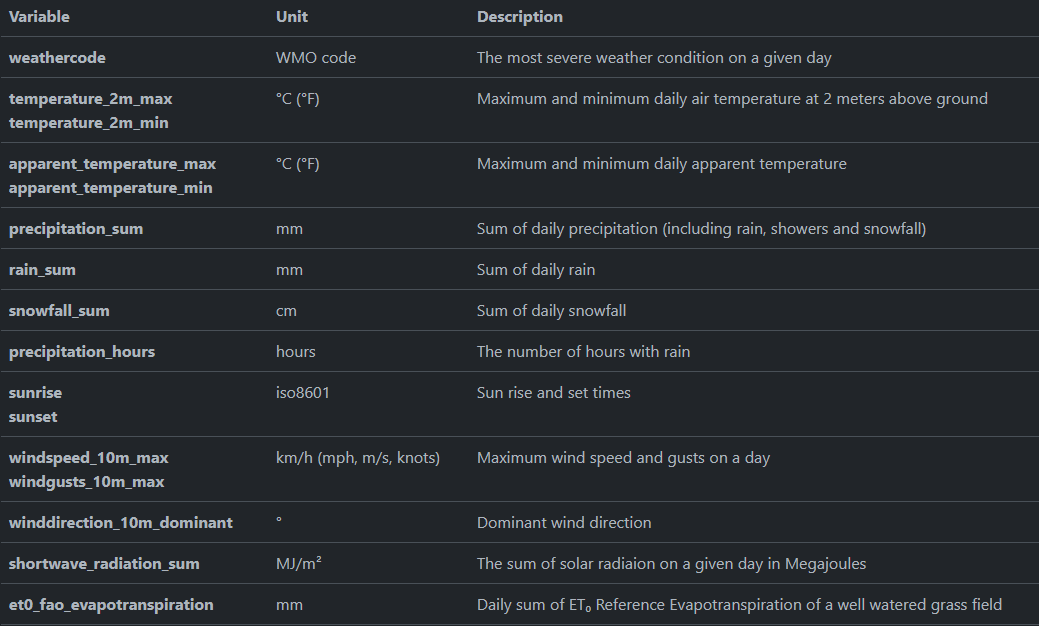


To discover the All URL parameters and more details about the data documentation check the link : API Documentation

## 2. Request Data

In [14]:
# Request data
url_API = 'https://archive-api.open-meteo.com/v1/archive?latitude=36.7323&longitude=3.0875&start_date=1990-01-01&end_date=2023-01-01&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration&timezone=auto'
#"https://archive-api.open-meteo.com/v1/archive?latitude=36.6985&longitude=3.2067&start_date=1990-01-01&end_date=2023-06-25&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,precipitation_hours,windspeed_10m_max,winddirection_10m_dominant&timezone=GMT"
weather_data = requests.get(url_API)
if weather_data.status_code == 200:
  weather_data = json.loads(weather_data.text)
else:
  print('The data are not available!')
# Create a data frame
weather_df = pd.DataFrame()
# Extract data from dictionary
time = weather_data['daily']['time']
weathercode = weather_data['daily']['weathercode']
temperature_2m_max = weather_data['daily']['temperature_2m_max']
temperature_2m_min = weather_data['daily']['temperature_2m_min']
temperature_2m_mean = weather_data['daily']['temperature_2m_mean']
apparent_temperature_mean = weather_data['daily']['apparent_temperature_mean']
apparent_temperature_max = weather_data['daily']['apparent_temperature_max']
apparent_temperature_min = weather_data['daily']['apparent_temperature_min']
precipitation_sum = weather_data['daily']['precipitation_sum']
precipitation_hours = weather_data['daily']['precipitation_hours']
windspeed_10m_max = weather_data['daily']['windspeed_10m_max']
windgusts_10m_max = weather_data['daily']['windgusts_10m_max']
winddirection_10m_dominant = weather_data['daily']['winddirection_10m_dominant']
et0_fao_evapotranspiration = weather_data['daily']['et0_fao_evapotranspiration']
# Create and add dataframe columns
weather_df['time'] = time
weather_df['weathercode'] = weathercode
weather_df['temperature_2m_max'] = temperature_2m_max
weather_df['temperature_2m_min'] = temperature_2m_min
weather_df['temperature_2m_mean'] = temperature_2m_mean
weather_df['apparent_temperature_mean'] = apparent_temperature_mean
weather_df['apparent_temperature_max'] = apparent_temperature_max
weather_df['apparent_temperature_min'] = apparent_temperature_min
weather_df['precipitation_sum'] = precipitation_sum
weather_df['precipitation_hours'] = precipitation_hours
weather_df['windspeed_10m_max'] = windspeed_10m_max
weather_df['windgusts_10m_max'] = windgusts_10m_max
weather_df['winddirection_10m_dominant'] = winddirection_10m_dominant
weather_df['et0_fao_evapotranspiration'] = et0_fao_evapotranspiration


In [15]:
# Set datetime as index
weather_df = weather_df.set_index('time')
weather_df.index = pd.to_datetime(weather_df.index)

# Step 2 : Feature engineering

The open-meteo historical Weather data exhibits the characteristics of a time series.

With the goal of predicting future weather conditions for the upcoming year, I plan to leverage machine learning algorithms. To construct an accurate prediction model, I will assess the performance of both LSTM and XGBoost algorithms and select the best one based on their respective accuracy.

In this step of the process, my objective is to identify the target parameters to be predicted according to the accurancy of the predections.

Additionally, I will identify the features that can effectively explain each target weather parameter.

For that, I decide to include not only lag parameters but also other relevant features to improve the predictive performance of the model.

While lagged values (previous observations) are commonly used as inputs to capture temporal dependencies in time series data, incorporating additional features can provide additional contextual information and potentially enhance the model's ability to make accurate predictions.


***1. Features to add in an LSTM model***
Here are a few considerations for selecting features in an LSTM model for time series forecasting:

* ***Lagged Parameters:*** Including lagged values of the target variable and other relevant variables as input features can help capture autocorrelation patterns and dependencies within the time series.

* ***Calendar Features:*** Incorporating calendar-related features such as day of the week, month, or season can account for recurring patterns or seasonality that may exist in the data.

* ***External Variables:*** If available, including relevant external variables that might influence the target variable can provide additional information to the model. For example, including weather variables like temperature or humidity when forecasting energy consumption can improve prediction accuracy.

* ***Trend and Seasonality:*** Explicitly encoding trend and seasonality components as features, such as polynomial terms or Fourier transformations, can help the model capture and predict these patterns more effectively.

* ***Rolling Statistics:*** Calculating rolling statistics like moving averages or cumulative sums as features can capture short-term or long-term trends in the data.

* ***Domain-Specific Features:*** Consider incorporating domain-specific features that are known to be influential in the context of the problem being addressed. These features might vary based on the specific application or industry.

2. ***Features to add in an XGBoost model***
In addition to lagged variables, here are some types of features we can consider incorporating using XGBoost:

* **Lagged Variables:** Similar to LSTM, including lagged values of the target variable and relevant predictors can capture temporal dependencies and historical patterns.

* ***Rolling Window Statistics:*** Calculating rolling window statistics such as rolling mean, standard deviation, or other aggregations can capture trends and patterns over a specific time window.

* ***Calendar Features:*** Adding calendar-related features like day of the week, month, quarter, or season can help capture recurring patterns and seasonality present in the data.

* ***Time-related Features:*** Including time-related features such as hour of the day, time of the year, or time since a specific event can capture diurnal or longer-term patterns in the data.

* ***Statistical Features:*** Calculating statistical features like minimum, maximum, median, or percentiles can capture the distributional characteristics of the data and provide additional insights.

* ***External Variables:*** Incorporating external variables that have an impact on the target variable can improve the predictive accuracy of the model. For example, including economic indicators, weather data, or social media sentiment can provide valuable context.

* ***Trend Features:*** Encoding trend-related features such as linear or polynomial terms, exponential decay, or moving averages can help the model capture and forecast long-term trends.

* ***Interaction Terms:*** Creating interaction terms between relevant predictors can capture complex relationships and interactions that might affect the target variable.

* ***Domain-Specific Features:*** Including domain-specific features that are known to be influential in the context of the problem can be beneficial. These features can vary based on the specific domain or industry.


The selection of features should be driven by the characteristics of the data and the problem to be solve.
Feature engineering and experimentation can help identify the most informative features for both LSTM & XGBoost models.
For that purpose, I choose to experiment with different combinations of features and observing their impact on model performance through validation and testing to help me identify the most informative features for my models.

To achieve this, I followed the subsequent steps:

* Employing XGBoost and LSTM on each parameter, I utilized calendar and lag features along with cross-validation methods to assess the accuracy of the models.

* By comparing the accuracy of the resulting models applied to each parameter, I can determine both the parameter to predict initially and the model to use for the prediction

* Conducting tests with various feature combinations on the remaining parameters using both XGBoost and LSTM algorithms to achieve the most accurate predictions.

Based on the R2 and MSE values obtained for each combination, the results of this process are as follows: :

* The first parameter to be predicted with the LSTM model using the target variable and lag features (lag364 & lag728) is apparent_temperature_mean ;

* The second parameter to be predicted with the LSTM model using the target variable, apparent_temperature_mean, and lag features (lag364 & lag728) is temperature_2m_mean ;

* The remaining parameters are forecasted using XGBoost, and the selection of features is based on their correlation coefficient with each target variable to be predicted.

Due to the winddirection_10m_dominant consistently demonstrating low accuracy across the various combinations I tested, I have chosen not to include it in the list of parameters to be predicted


## 1. Apply XGBoost on all features using calender and lags features only

In [16]:
XGBoost_features = ['month', 'year', 'dayofyear', 'lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
cols = list(weather_df.columns)
estimators = 700
XGBoost_result_dic = {}
for col in cols:
  result = select_target_XGBoost(weather_df, col, XGBoost_features, estimators)
  XGBoost_result_dic[col] = result

[09:17:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:31.32109	validation_1-rmse:34.60269
[100]	validation_0-rmse:24.87523	validation_1-rmse:28.01662
[200]	validation_0-rmse:23.77888	validation_1-rmse:27.07733
[300]	validation_0-rmse:23.53585	validation_1-rmse:27.02719
[308]	validation_0-rmse:23.52499	validation_1-rmse:27.02197
[09:17:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:31.43952	validation_1-rmse:30.90271
[100]	validation_0-rmse:24.96666	validation_1-rmse:25.20585
[200]	validation_0-rmse:23.86748	validation_1-rmse:24.66516
[251]	validation_0-rmse:23.71635	validation_1-rmse:24.72180
[09:18:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:31.42253	validation_1-rmse:28.94941
[100]	validation_0-rmse:24.99345	validation_1-rms

In [17]:
XGBoost_R2_dict = {}
for parameter in cols:
    XGBoost_R2_dict[parameter] = round(np.mean(XGBoost_result_dic[parameter][3]), 2)
print(f'The R2 for each parameter : \n {XGBoost_R2_dict}')
XGBoost_max_R2 = max(XGBoost_R2_dict, key=XGBoost_R2_dict.get)
print(f'The best predected parameter is : {XGBoost_max_R2} with R2 = {XGBoost_R2_dict[XGBoost_max_R2]}')

The R2 for each parameter : 
 {'weathercode': 0.07, 'temperature_2m_max': 0.77, 'temperature_2m_min': 0.81, 'temperature_2m_mean': 0.86, 'apparent_temperature_mean': 0.88, 'apparent_temperature_max': 0.8, 'apparent_temperature_min': 0.86, 'precipitation_sum': 0.05, 'precipitation_hours': 0.06, 'windspeed_10m_max': -0.03, 'windgusts_10m_max': -0.01, 'winddirection_10m_dominant': 0.07, 'et0_fao_evapotranspiration': 0.75}
The best predected parameter is : apparent_temperature_mean with R2 = 0.88


## 2. Apply LSTM on all features using the target parameter, calender and lags as features  

In [18]:
cols = list(weather_df.columns)
LSTM_result_dic = {}
for col in cols:
  result = select_target_LSTM(weather_df, col, [col, 'lag364', 'lag728'], 5, 364)
  LSTM_result_dic[col] = result

Epoch 1/5
85/85 - 4s - loss: 681.0043 - 4s/epoch - 43ms/step
Epoch 2/5
85/85 - 1s - loss: 624.5488 - 1s/epoch - 14ms/step
Epoch 3/5
85/85 - 1s - loss: 624.8222 - 1s/epoch - 13ms/step
Epoch 4/5
85/85 - 1s - loss: 624.9237 - 1s/epoch - 13ms/step
Epoch 5/5
85/85 - 1s - loss: 625.1744 - 1s/epoch - 13ms/step
12/12 [==============================] - 1s 3ms/step
Epoch 1/5
88/88 - 3s - loss: 679.8883 - 3s/epoch - 39ms/step
Epoch 2/5
88/88 - 1s - loss: 625.7040 - 1s/epoch - 14ms/step
Epoch 3/5
88/88 - 1s - loss: 625.4750 - 1s/epoch - 14ms/step
Epoch 4/5
88/88 - 1s - loss: 625.8922 - 1s/epoch - 14ms/step
Epoch 5/5
88/88 - 1s - loss: 625.6230 - 1s/epoch - 14ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
91/91 - 3s - loss: 675.3353 - 3s/epoch - 38ms/step
Epoch 2/5
91/91 - 1s - loss: 626.5501 - 1s/epoch - 14ms/step
Epoch 3/5
91/91 - 1s - loss: 626.4619 - 1s/epoch - 13ms/step
Epoch 4/5
91/91 - 1s - loss: 626.5870 - 1s/epoch - 14ms/step
Epoch 5/5
91/91 - 1s - loss: 626.9888 - 

In [19]:
LSTM_R2_dict = {}
for parameter in cols:
    LSTM_R2_dict[parameter] = round(np.mean(LSTM_result_dic[parameter][3]), 2)
print(f'The R2 for each parameter : \n {LSTM_R2_dict}')
LSTM_max_R2 = max(LSTM_R2_dict, key=LSTM_R2_dict.get)
print(f'The best predected parameter is : {LSTM_max_R2} with R2 = {LSTM_R2_dict[LSTM_max_R2]}')

The R2 for each parameter : 
 {'weathercode': 0.1, 'temperature_2m_max': 0.81, 'temperature_2m_min': 0.85, 'temperature_2m_mean': 0.9, 'apparent_temperature_mean': 0.93, 'apparent_temperature_max': 0.83, 'apparent_temperature_min': 0.9, 'precipitation_sum': 0.05, 'precipitation_hours': 0.09, 'windspeed_10m_max': -0.02, 'windgusts_10m_max': -0.02, 'winddirection_10m_dominant': -0.01, 'et0_fao_evapotranspiration': 0.76}
The best predected parameter is : apparent_temperature_mean with R2 = 0.93


# Step 3 : Modeling

## 1. Apply LSTM model to predict apparent_temperature_mean


In [20]:
result_apparent_temperature_mean = select_target_LSTM(weather_df, 'apparent_temperature_mean', ['apparent_temperature_mean', 'lag364', 'lag728'], 7, 364)

Epoch 1/7
85/85 - 3s - loss: 52.4645 - 3s/epoch - 41ms/step
Epoch 2/7
85/85 - 1s - loss: 24.2239 - 1s/epoch - 14ms/step
Epoch 3/7
85/85 - 1s - loss: 22.9508 - 1s/epoch - 15ms/step
Epoch 4/7
85/85 - 1s - loss: 22.8574 - 1s/epoch - 14ms/step
Epoch 5/7
85/85 - 1s - loss: 22.9121 - 1s/epoch - 14ms/step
Epoch 6/7
85/85 - 1s - loss: 22.7845 - 1s/epoch - 15ms/step
Epoch 7/7
85/85 - 1s - loss: 22.8428 - 1s/epoch - 14ms/step
12/12 [==============================] - 1s 3ms/step
Epoch 1/7
88/88 - 4s - loss: 51.7553 - 4s/epoch - 43ms/step
Epoch 2/7
88/88 - 1s - loss: 24.0783 - 1s/epoch - 14ms/step
Epoch 3/7
88/88 - 1s - loss: 22.5650 - 1s/epoch - 14ms/step
Epoch 4/7
88/88 - 1s - loss: 22.3830 - 1s/epoch - 15ms/step
Epoch 5/7
88/88 - 1s - loss: 22.5477 - 1s/epoch - 15ms/step
Epoch 6/7
88/88 - 1s - loss: 22.3642 - 1s/epoch - 14ms/step
Epoch 7/7
88/88 - 1s - loss: 22.3323 - 1s/epoch - 14ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/7
91/91 - 4s - loss: 50.6630 - 4s/epoch - 39ms

In [21]:
evaluation(result_apparent_temperature_mean[1], result_apparent_temperature_mean[3])

MSEs across folds 2.0494
Fold mses:[2.0859740790096235, 2.1410703016259256, 1.8430271614813758, 2.2052866109721396, 1.9715042922394799]
R2s across folds 0.9277
Fold R2s:[0.926242787304288, 0.9277055400542911, 0.9328888152341666, 0.9155133405831313, 0.9361254676575655]


## 2. Apply LSTM model to predict temperature_2m_mean

In [22]:
result_temperature_2m_mean = select_target_LSTM(weather_df, 'temperature_2m_mean', ['temperature_2m_mean', 'lag364', 'lag728'], 7, 364)

Epoch 1/7
85/85 - 4s - loss: 50.4610 - 4s/epoch - 41ms/step
Epoch 2/7
85/85 - 1s - loss: 20.6296 - 1s/epoch - 14ms/step
Epoch 3/7
85/85 - 1s - loss: 18.8055 - 1s/epoch - 14ms/step
Epoch 4/7
85/85 - 1s - loss: 18.6472 - 1s/epoch - 15ms/step
Epoch 5/7
85/85 - 1s - loss: 18.6933 - 1s/epoch - 14ms/step
Epoch 6/7
85/85 - 1s - loss: 18.7721 - 1s/epoch - 14ms/step
Epoch 7/7
85/85 - 1s - loss: 18.6991 - 1s/epoch - 14ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/7
88/88 - 4s - loss: 46.7336 - 4s/epoch - 43ms/step
Epoch 2/7
88/88 - 1s - loss: 19.9698 - 1s/epoch - 14ms/step
Epoch 3/7
88/88 - 1s - loss: 18.3401 - 1s/epoch - 13ms/step
Epoch 4/7
88/88 - 1s - loss: 18.4169 - 1s/epoch - 14ms/step
Epoch 5/7
88/88 - 1s - loss: 18.3545 - 1s/epoch - 13ms/step
Epoch 6/7
88/88 - 1s - loss: 18.3175 - 1s/epoch - 13ms/step
Epoch 7/7
88/88 - 1s - loss: 18.3610 - 1s/epoch - 13ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/7
91/91 - 4s - loss: 46.9383 - 4s/epoch - 39ms

In [23]:
evaluation(result_temperature_2m_mean[1], result_temperature_2m_mean[3])

MSEs across folds 1.9437
Fold mses:[2.0043185623092676, 2.124576403936007, 1.8505675406609228, 1.7901875977902968, 1.9490756954733295]
R2s across folds 0.8956
Fold R2s:[0.8799456353810873, 0.8848692000959498, 0.8953351235009153, 0.9119438517408114, 0.9058947752163892]


## 3. Testing multiple combinations of features using LSTM and XGBoost to predict each parameter

### temperature_2m_max

In [24]:
result_temperature_2m_max = select_target_LSTM(weather_df, 'temperature_2m_max', ['temperature_2m_max', 'lag364', 'lag728'], 5, 364)

Epoch 1/5
85/85 - 3s - loss: 86.9197 - 3s/epoch - 40ms/step
Epoch 2/5
85/85 - 1s - loss: 37.2949 - 1s/epoch - 13ms/step
Epoch 3/5
85/85 - 1s - loss: 32.9109 - 1s/epoch - 14ms/step
Epoch 4/5
85/85 - 1s - loss: 32.6180 - 1s/epoch - 13ms/step
Epoch 5/5
85/85 - 1s - loss: 32.4988 - 1s/epoch - 13ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
88/88 - 3s - loss: 81.5771 - 3s/epoch - 39ms/step
Epoch 2/5
88/88 - 1s - loss: 35.1896 - 1s/epoch - 14ms/step
Epoch 3/5
88/88 - 1s - loss: 32.0136 - 1s/epoch - 13ms/step
Epoch 4/5
88/88 - 1s - loss: 32.1223 - 1s/epoch - 14ms/step
Epoch 5/5
88/88 - 1s - loss: 31.8773 - 1s/epoch - 15ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
91/91 - 3s - loss: 78.9609 - 3s/epoch - 37ms/step
Epoch 2/5
91/91 - 1s - loss: 35.5544 - 1s/epoch - 13ms/step
Epoch 3/5
91/91 - 1s - loss: 31.8228 - 1s/epoch - 13ms/step
Epoch 4/5
91/91 - 1s - loss: 31.5173 - 1s/epoch - 13ms/step
Epoch 5/5
91/91 - 1s - loss: 31.5101 - 1s/epoch - 13ms

In [25]:
evaluation(result_temperature_2m_max[1], result_temperature_2m_max[3])

MSEs across folds 2.9458
Fold mses:[2.792300986701235, 3.0580008906334206, 2.9741226416955384, 2.9449011074606832, 2.95952310970434]
R2s across folds 0.8126
Fold R2s:[0.8173009077852971, 0.8125538984333629, 0.7846365416401422, 0.8183351057877566, 0.8299890880990176]


In [26]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
estimators = 700
result_temperature_2m_max = select_target_XGBoost(weather_df, 'temperature_2m_max', XGBoost_features, estimators)

[09:33:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22.66091	validation_1-rmse:22.47507
[100]	validation_0-rmse:8.43616	validation_1-rmse:8.21842
[200]	validation_0-rmse:3.38892	validation_1-rmse:3.17951
[300]	validation_0-rmse:1.83179	validation_1-rmse:1.68885
[400]	validation_0-rmse:1.48344	validation_1-rmse:1.41943
[500]	validation_0-rmse:1.41485	validation_1-rmse:1.38721
[600]	validation_0-rmse:1.39624	validation_1-rmse:1.38115
[687]	validation_0-rmse:1.38884	validation_1-rmse:1.38059
[09:33:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22.65462	validation_1-rmse:23.27047
[100]	validation_0-rmse:8.43346	validation_1-rmse:8.63772
[200]	validation_0-rmse:3.38768	validation_1-rmse:3.42379
[300]	validation_0-rmse:1.83105	validation_1-rmse:1.83804
[400]	validation_0-rmse:1.48273	validation_1-rmse:1.52386
[500]	va

In [27]:
evaluation(result_temperature_2m_max[1], result_temperature_2m_max[3])

MSEs across folds 1.4595
Fold mses:[1.3805579197931186, 1.454790818713144, 1.497336906075586, 1.3982277812971355, 1.5666886027416655]
R2s across folds 0.9540
Fold R2s:[0.955264280821691, 0.9577087605040441, 0.9454759952334533, 0.9593907191603177, 0.9523409486459363]


### temperature_2m_min

In [28]:
result_temperature_2m_min = select_target_LSTM(weather_df, 'temperature_2m_min', ['temperature_2m_min', 'lag364', 'lag728'], 5, 364)

Epoch 1/5
85/85 - 3s - loss: 30.9752 - 3s/epoch - 39ms/step
Epoch 2/5
85/85 - 1s - loss: 15.8765 - 1s/epoch - 13ms/step
Epoch 3/5
85/85 - 1s - loss: 14.6852 - 1s/epoch - 14ms/step
Epoch 4/5
85/85 - 1s - loss: 14.6450 - 1s/epoch - 13ms/step
Epoch 5/5
85/85 - 1s - loss: 14.6654 - 1s/epoch - 14ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
88/88 - 3s - loss: 30.1802 - 3s/epoch - 39ms/step
Epoch 2/5
88/88 - 1s - loss: 15.7146 - 1s/epoch - 13ms/step
Epoch 3/5
88/88 - 1s - loss: 14.5461 - 1s/epoch - 13ms/step
Epoch 4/5
88/88 - 1s - loss: 14.4762 - 1s/epoch - 14ms/step
Epoch 5/5
88/88 - 1s - loss: 14.4989 - 1s/epoch - 15ms/step
12/12 [==============================] - 0s 2ms/step
Epoch 1/5
91/91 - 4s - loss: 30.5934 - 4s/epoch - 49ms/step
Epoch 2/5
91/91 - 1s - loss: 15.2664 - 1s/epoch - 14ms/step
Epoch 3/5
91/91 - 1s - loss: 14.2823 - 1s/epoch - 13ms/step
Epoch 4/5
91/91 - 1s - loss: 14.2504 - 1s/epoch - 14ms/step
Epoch 5/5
91/91 - 1s - loss: 14.2282 - 1s/epoch - 13ms

In [29]:
evaluation(result_temperature_2m_min[1], result_temperature_2m_min[3])

MSEs across folds 2.2210
Fold mses:[2.1354158879197143, 2.100761384172657, 2.1743817253393822, 2.2460225185136693, 2.4483072465308964]
R2s across folds 0.8326
Fold R2s:[0.8335637264578354, 0.8673103027002924, 0.8206542273686501, 0.825476348663431, 0.8159582560960983]


In [30]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
estimators = 700
result_temperature_2m_min = select_target_XGBoost(weather_df, 'temperature_2m_min', XGBoost_features, estimators)

[09:34:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13.61706	validation_1-rmse:13.78396
[100]	validation_0-rmse:5.18759	validation_1-rmse:5.21891
[200]	validation_0-rmse:2.27457	validation_1-rmse:2.22626
[300]	validation_0-rmse:1.40272	validation_1-rmse:1.30083
[400]	validation_0-rmse:1.17064	validation_1-rmse:1.06960
[500]	validation_0-rmse:1.08985	validation_1-rmse:1.00498
[600]	validation_0-rmse:1.04344	validation_1-rmse:0.97167
[699]	validation_0-rmse:1.00178	validation_1-rmse:0.93808
[09:34:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13.62314	validation_1-rmse:14.25719
[100]	validation_0-rmse:5.18835	validation_1-rmse:5.53123
[200]	validation_0-rmse:2.27327	validation_1-rmse:2.48844
[300]	validation_0-rmse:1.40020	validation_1-rmse:1.52623
[400]	validation_0-rmse:1.16735	validation_1-rmse:1.24560
[500]	va

In [31]:
evaluation(result_temperature_2m_min[1], result_temperature_2m_min[3])

MSEs across folds 1.0618
Fold mses:[0.9380794150415878, 1.0422921904125377, 1.0976831968634342, 1.159244998209904, 1.071824950376252]
R2s across folds 0.9617
Fold R2s:[0.9678130101395613, 0.9673283802468583, 0.954600319205213, 0.9536524529305078, 0.9648567751785636]


### apparent_temperature_max

In [32]:
result_apparent_temperature_max = select_target_LSTM(weather_df, 'apparent_temperature_max',
 ['apparent_temperature_max','temperature_2m_min', 'lag364', 'lag728'], 5, 364)

Epoch 1/5
113/113 - 4s - loss: 88.9217 - 4s/epoch - 34ms/step
Epoch 2/5
113/113 - 2s - loss: 59.9965 - 2s/epoch - 14ms/step
Epoch 3/5
113/113 - 2s - loss: 58.7664 - 2s/epoch - 14ms/step
Epoch 4/5
113/113 - 2s - loss: 58.8475 - 2s/epoch - 14ms/step
Epoch 5/5
113/113 - 2s - loss: 58.6888 - 2s/epoch - 14ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
117/117 - 4s - loss: 85.9272 - 4s/epoch - 35ms/step
Epoch 2/5
117/117 - 2s - loss: 59.1703 - 2s/epoch - 14ms/step
Epoch 3/5
117/117 - 2s - loss: 58.6123 - 2s/epoch - 14ms/step
Epoch 4/5
117/117 - 2s - loss: 58.5804 - 2s/epoch - 14ms/step
Epoch 5/5
117/117 - 2s - loss: 58.4118 - 2s/epoch - 14ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
121/121 - 5s - loss: 84.8865 - 5s/epoch - 40ms/step
Epoch 2/5
121/121 - 2s - loss: 59.2869 - 2s/epoch - 13ms/step
Epoch 3/5
121/121 - 2s - loss: 58.1114 - 2s/epoch - 13ms/step
Epoch 4/5
121/121 - 2s - loss: 58.1013 - 2s/epoch - 14ms/step
Epoch 5/5
121/121 - 2s - l

In [33]:
evaluation(result_apparent_temperature_max[1], result_apparent_temperature_max[3])

MSEs across folds 4.7062
Fold mses:[4.684620573606829, 4.746609011335249, 4.4481744305344755, 4.593291460292334, 5.058520060434461]
R2s across folds 0.6894
Fold R2s:[0.690706481768182, 0.7105533413899365, 0.6788056135428746, 0.7096942697348262, 0.6573155982263101]


In [34]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
estimators = 700
result_apparent_temperature_max = select_target_XGBoost(weather_df, 'apparent_temperature_max', XGBoost_features, estimators)

[09:36:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22.70744	validation_1-rmse:22.83828
[100]	validation_0-rmse:8.44038	validation_1-rmse:8.50972
[200]	validation_0-rmse:3.30241	validation_1-rmse:3.34477
[300]	validation_0-rmse:1.56368	validation_1-rmse:1.59540
[400]	validation_0-rmse:1.06730	validation_1-rmse:1.09484
[500]	validation_0-rmse:0.93523	validation_1-rmse:0.96498
[600]	validation_0-rmse:0.89333	validation_1-rmse:0.92730
[699]	validation_0-rmse:0.86256	validation_1-rmse:0.90101
[09:36:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22.71197	validation_1-rmse:23.25495
[100]	validation_0-rmse:8.44192	validation_1-rmse:8.55984
[200]	validation_0-rmse:3.30248	validation_1-rmse:3.23790
[300]	validation_0-rmse:1.56374	validation_1-rmse:1.47292
[400]	validation_0-rmse:1.06791	validation_1-rmse:1.03439
[500]	va

In [35]:
evaluation(result_apparent_temperature_max[1], result_apparent_temperature_max[3])

MSEs across folds 0.9291
Fold mses:[0.9010088372979342, 0.9178395375729836, 0.9356600691998782, 0.9095217855091143, 0.9816977261560131]
R2s across folds 0.9879
Fold R2s:[0.9885500364980083, 0.9892078767640012, 0.9858016127424968, 0.9887340851486055, 0.9870830918942571]


### apparent_temperature_min

In [36]:
result_apparent_temperature_min = select_target_LSTM(weather_df, 'apparent_temperature_min', ['apparent_temperature_min',
                                                                                              'apparent_temperature_max','temperature_2m_min',
                                                                                              'lag364', 'lag728'], 5, 364)

Epoch 1/5
141/141 - 4s - loss: 51.9979 - 4s/epoch - 29ms/step
Epoch 2/5
141/141 - 2s - loss: 40.6577 - 2s/epoch - 13ms/step
Epoch 3/5
141/141 - 2s - loss: 40.3553 - 2s/epoch - 12ms/step
Epoch 4/5
141/141 - 2s - loss: 40.3198 - 2s/epoch - 13ms/step
Epoch 5/5
141/141 - 2s - loss: 40.2288 - 2s/epoch - 13ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
146/146 - 5s - loss: 50.6650 - 5s/epoch - 34ms/step
Epoch 2/5
146/146 - 2s - loss: 40.3382 - 2s/epoch - 13ms/step
Epoch 3/5
146/146 - 2s - loss: 40.1681 - 2s/epoch - 13ms/step
Epoch 4/5
146/146 - 2s - loss: 40.1122 - 2s/epoch - 13ms/step
Epoch 5/5
146/146 - 2s - loss: 40.0208 - 2s/epoch - 13ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
151/151 - 4s - loss: 51.1452 - 4s/epoch - 28ms/step
Epoch 2/5
151/151 - 2s - loss: 40.2772 - 2s/epoch - 15ms/step
Epoch 3/5
151/151 - 2s - loss: 40.0415 - 2s/epoch - 13ms/step
Epoch 4/5
151/151 - 2s - loss: 39.8484 - 2s/epoch - 13ms/step
Epoch 5/5
151/151 - 2s - l

In [37]:
evaluation(result_apparent_temperature_min[1], result_apparent_temperature_min[3])

MSEs across folds 2.8214
Fold mses:[2.905366695577748, 3.030883855299413, 2.688104119728718, 2.7077054215483884, 2.7750798484295744]
R2s across folds 0.8450
Fold R2s:[0.8391767551811574, 0.8401373483218174, 0.8377084028529413, 0.8523442331800848, 0.855824544964521]


In [38]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
estimators = 700
result_apparent_temperature_min = select_target_XGBoost(weather_df, 'apparent_temperature_min', XGBoost_features, estimators)

[09:37:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13.51447	validation_1-rmse:13.96186
[100]	validation_0-rmse:5.08322	validation_1-rmse:5.37255
[200]	validation_0-rmse:2.06994	validation_1-rmse:2.26417
[300]	validation_0-rmse:1.11040	validation_1-rmse:1.21672
[400]	validation_0-rmse:0.85050	validation_1-rmse:0.89943
[500]	validation_0-rmse:0.77116	validation_1-rmse:0.80214
[600]	validation_0-rmse:0.73659	validation_1-rmse:0.76585
[699]	validation_0-rmse:0.71633	validation_1-rmse:0.74662
[09:37:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13.53016	validation_1-rmse:14.33307
[100]	validation_0-rmse:5.08853	validation_1-rmse:5.49250
[200]	validation_0-rmse:2.07098	validation_1-rmse:2.30228
[300]	validation_0-rmse:1.11020	validation_1-rmse:1.26376
[400]	validation_0-rmse:0.85039	validation_1-rmse:0.95139
[500]	va

In [39]:
evaluation(result_apparent_temperature_min[1], result_apparent_temperature_min[3])

MSEs across folds 0.7835
Fold mses:[0.7466175424669712, 0.7754314749715183, 0.7222805441567867, 0.8266844864228696, 0.8467345491882596]
R2s across folds 0.9880
Fold R2s:[0.9893660269636784, 0.9895314207585187, 0.9883471009156867, 0.9863112578359281, 0.986603923783399]


### et0_fao_evapotranspiration

In [40]:
result_et0_fao_evapotranspiration = select_target_LSTM(weather_df, 'et0_fao_evapotranspiration', ['apparent_temperature_min', 'et0_fao_evapotranspiration',
                                                                                              'apparent_temperature_max','temperature_2m_min',
                                                                                              'lag364', 'lag728'], 5, 364)

Epoch 1/5
169/169 - 4s - loss: 73.2845 - 4s/epoch - 26ms/step
Epoch 2/5
169/169 - 2s - loss: 61.2534 - 2s/epoch - 13ms/step
Epoch 3/5
169/169 - 2s - loss: 58.0076 - 2s/epoch - 15ms/step
Epoch 4/5
169/169 - 2s - loss: 57.5503 - 2s/epoch - 13ms/step
Epoch 5/5
169/169 - 2s - loss: 57.3574 - 2s/epoch - 13ms/step
12/12 [==============================] - 1s 3ms/step
Epoch 1/5
175/175 - 5s - loss: 73.8668 - 5s/epoch - 27ms/step
Epoch 2/5
175/175 - 2s - loss: 61.1550 - 2s/epoch - 13ms/step
Epoch 3/5
175/175 - 2s - loss: 58.1647 - 2s/epoch - 13ms/step
Epoch 4/5
175/175 - 2s - loss: 57.5717 - 2s/epoch - 13ms/step
Epoch 5/5
175/175 - 2s - loss: 57.3752 - 2s/epoch - 13ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
181/181 - 5s - loss: 73.5246 - 5s/epoch - 26ms/step
Epoch 2/5
181/181 - 2s - loss: 60.9712 - 2s/epoch - 14ms/step
Epoch 3/5
181/181 - 3s - loss: 58.3473 - 3s/epoch - 15ms/step
Epoch 4/5
181/181 - 2s - loss: 57.7321 - 2s/epoch - 13ms/step
Epoch 5/5
181/181 - 2s - l

In [41]:
evaluation(result_et0_fao_evapotranspiration[1], result_et0_fao_evapotranspiration[3])

MSEs across folds 7.0869
Fold mses:[7.248091203737007, 7.550340848943406, 6.9332557644246915, 6.780425099390646, 6.92245075889113]
R2s across folds -13.8753
Fold R2s:[-18.180463753567214, -15.254539438584356, -11.876570557419619, -12.04240025814028, -12.022476866670766]


In [42]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min','lag364', 'lag728', 'lag1092' ]
estimators = 700
result_et0_fao_evapotranspiration = select_target_XGBoost(weather_df, 'et0_fao_evapotranspiration', XGBoost_features, estimators)

[09:39:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.59900	validation_1-rmse:3.39077
[100]	validation_0-rmse:1.46409	validation_1-rmse:1.30189
[200]	validation_0-rmse:0.77453	validation_1-rmse:0.70011
[300]	validation_0-rmse:0.59088	validation_1-rmse:0.59540
[400]	validation_0-rmse:0.53930	validation_1-rmse:0.57491
[500]	validation_0-rmse:0.51899	validation_1-rmse:0.56878
[600]	validation_0-rmse:0.50466	validation_1-rmse:0.56184
[699]	validation_0-rmse:0.49057	validation_1-rmse:0.55296
[09:39:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.59211	validation_1-rmse:3.79886
[100]	validation_0-rmse:1.46209	validation_1-rmse:1.62471
[200]	validation_0-rmse:0.77467	validation_1-rmse:0.90856
[300]	validation_0-rmse:0.59124	validation_1-rmse:0.69229
[400]	validation_0-rmse:0.54025	validation_1-rmse:0.61865
[500]	valida

In [43]:
evaluation(result_et0_fao_evapotranspiration[1], result_et0_fao_evapotranspiration[3])

MSEs across folds 0.5620
Fold mses:[0.5529615174033028, 0.5531626177482436, 0.5964590790602802, 0.5650319831300625, 0.5423745677073348]
R2s across folds 0.9071
Fold R2s:[0.8881530735082375, 0.9129361698232616, 0.9048564911696227, 0.9095614396621547, 0.920197991586025]


### precipitation_hours

In [44]:
result_precipitation_hours= select_target_LSTM(weather_df, 'precipitation_hours', ['apparent_temperature_mean','apparent_temperature_min', 'precipitation_hours',
                                                                                              'apparent_temperature_max','temperature_2m_min', 'temperature_2m_mean',
                                                                                       'temperature_2m_max', 'lag364', 'lag728'], 5, 364)

Epoch 1/5
253/253 - 7s - loss: 103.2219 - 7s/epoch - 26ms/step
Epoch 2/5
253/253 - 3s - loss: 93.4735 - 3s/epoch - 13ms/step
Epoch 3/5
253/253 - 3s - loss: 93.4697 - 3s/epoch - 13ms/step
Epoch 4/5
253/253 - 3s - loss: 93.4740 - 3s/epoch - 13ms/step
Epoch 5/5
253/253 - 3s - loss: 93.5414 - 3s/epoch - 13ms/step
12/12 [==============================] - 1s 3ms/step
Epoch 1/5
262/262 - 6s - loss: 103.5155 - 6s/epoch - 23ms/step
Epoch 2/5
262/262 - 4s - loss: 93.5463 - 4s/epoch - 13ms/step
Epoch 3/5
262/262 - 4s - loss: 93.4940 - 4s/epoch - 13ms/step
Epoch 4/5
262/262 - 3s - loss: 93.5506 - 3s/epoch - 13ms/step
Epoch 5/5
262/262 - 3s - loss: 93.5153 - 3s/epoch - 13ms/step
12/12 [==============================] - 0s 3ms/step
Epoch 1/5
271/271 - 6s - loss: 103.3373 - 6s/epoch - 22ms/step
Epoch 2/5
271/271 - 4s - loss: 93.7054 - 4s/epoch - 13ms/step
Epoch 3/5
271/271 - 4s - loss: 93.7930 - 4s/epoch - 14ms/step
Epoch 4/5
271/271 - 4s - loss: 93.6797 - 4s/epoch - 14ms/step
Epoch 5/5
271/271 - 4s 

In [45]:
evaluation(result_precipitation_hours[1], result_precipitation_hours[3])

MSEs across folds 12.9098
Fold mses:[12.191430994042154, 12.214333509318616, 13.371631335556541, 13.359380218048273, 13.412254270162698]
R2s across folds -5.6108
Fold R2s:[-4.037664561515573, -5.0715438590185995, -7.617623086285775, -5.718904846306567, -5.608392387131019]


In [46]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min', 'et0_fao_evapotranspiration', 'lag364',
                    'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
result_precipitation_hours = select_target_XGBoost(weather_df, 'precipitation_hours', XGBoost_features, estimators)

[09:41:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.52570	validation_1-rmse:5.99579
[100]	validation_0-rmse:3.91968	validation_1-rmse:4.42176
[200]	validation_0-rmse:3.36759	validation_1-rmse:3.79381
[300]	validation_0-rmse:3.13997	validation_1-rmse:3.46676
[400]	validation_0-rmse:2.92518	validation_1-rmse:3.20084
[500]	validation_0-rmse:2.80341	validation_1-rmse:3.02474
[600]	validation_0-rmse:2.73239	validation_1-rmse:2.92806
[699]	validation_0-rmse:2.68722	validation_1-rmse:2.87032
[09:41:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.54230	validation_1-rmse:5.29528
[100]	validation_0-rmse:3.92971	validation_1-rmse:3.92378
[200]	validation_0-rmse:3.37531	validation_1-rmse:3.50737
[300]	validation_0-rmse:3.15048	validation_1-rmse:3.35663
[400]	validation_0-rmse:2.96378	validation_1-rmse:3.20616
[500]	valida

In [47]:
evaluation(result_precipitation_hours[1], result_precipitation_hours[3])

MSEs across folds 3.0163
Fold mses:[2.8701044288074162, 3.001387634537943, 3.111787297315699, 2.8734985463105462, 3.2247547157044067]
R2s across folds 0.6396
Fold R2s:[0.7202864874748293, 0.6326298179956364, 0.5322856155230049, 0.6958535735561523, 0.6171878452466424]


### precipitation_sum

In [48]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min', 'et0_fao_evapotranspiration', 'precipitation_hours',
                    'lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
result_precipitation_sum = select_target_XGBoost(weather_df, 'precipitation_sum', XGBoost_features, estimators)

[09:41:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.57706	validation_1-rmse:5.56428
[100]	validation_0-rmse:2.68847	validation_1-rmse:3.41772
[200]	validation_0-rmse:2.23075	validation_1-rmse:2.88838
[300]	validation_0-rmse:2.08154	validation_1-rmse:2.67243
[400]	validation_0-rmse:2.01667	validation_1-rmse:2.59118
[500]	validation_0-rmse:1.97369	validation_1-rmse:2.56673
[600]	validation_0-rmse:1.94651	validation_1-rmse:2.55372
[699]	validation_0-rmse:1.92149	validation_1-rmse:2.54271
[09:41:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.61441	validation_1-rmse:3.64749
[100]	validation_0-rmse:2.70820	validation_1-rmse:1.89260
[200]	validation_0-rmse:2.24720	validation_1-rmse:1.67925
[243]	validation_0-rmse:2.16644	validation_1-rmse:1.72032
[09:41:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear

In [49]:
evaluation(result_precipitation_sum[1], result_precipitation_sum[3])

MSEs across folds 1.9659
Fold mses:[2.5427121258526704, 1.6760425193899362, 1.9782711664353092, 1.7571269846325874, 1.87541825166797]
R2s across folds 0.7795
Fold R2s:[0.7751701083259194, 0.7811414448819595, 0.7462954562116333, 0.8309531279933514, 0.7641108924641851]


### windspeed_10m_max

In [50]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min', 'et0_fao_evapotranspiration', 'precipitation_hours',
                    'precipitation_sum','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
result_windspeed_10m_max = select_target_XGBoost(weather_df, 'windspeed_10m_max', XGBoost_features, estimators)

[09:42:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:19.50726	validation_1-rmse:19.78255
[100]	validation_0-rmse:8.89574	validation_1-rmse:8.98938
[200]	validation_0-rmse:5.86271	validation_1-rmse:5.92391
[300]	validation_0-rmse:5.07593	validation_1-rmse:5.19303
[400]	validation_0-rmse:4.73903	validation_1-rmse:4.91306
[500]	validation_0-rmse:4.52497	validation_1-rmse:4.76392
[600]	validation_0-rmse:4.36354	validation_1-rmse:4.65082
[699]	validation_0-rmse:4.23369	validation_1-rmse:4.56573
[09:42:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:19.51765	validation_1-rmse:20.74159
[100]	validation_0-rmse:8.89519	validation_1-rmse:10.09200
[200]	validation_0-rmse:5.85654	validation_1-rmse:6.85715
[300]	validation_0-rmse:5.06968	validation_1-rmse:5.95496
[400]	validation_0-rmse:4.74956	validation_1-rmse:5.56012
[500]	v

In [51]:
evaluation(result_windspeed_10m_max[1], result_windspeed_10m_max[3])

MSEs across folds 4.7869
Fold mses:[4.565732386588996, 5.1028411518685175, 4.436961720610824, 5.14212169621563, 4.686745123422063]
R2s across folds 0.5632
Fold R2s:[0.6121399405832259, 0.5590223882285161, 0.6300305469089267, 0.49587633625045135, 0.5187925194800949]


### windgusts_10m_max

In [52]:
XGBoost_features = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min', 'et0_fao_evapotranspiration', 'precipitation_hours',
                    'precipitation_sum', 'windspeed_10m_max','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
result_windgusts_10m_max = select_target_XGBoost(weather_df, 'windgusts_10m_max', XGBoost_features, estimators)

[09:42:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:38.47168	validation_1-rmse:38.68724
[100]	validation_0-rmse:14.50889	validation_1-rmse:14.41472
[200]	validation_0-rmse:6.17720	validation_1-rmse:6.05091
[300]	validation_0-rmse:3.76730	validation_1-rmse:3.80526
[400]	validation_0-rmse:3.23710	validation_1-rmse:3.42388
[500]	validation_0-rmse:3.12909	validation_1-rmse:3.39016
[566]	validation_0-rmse:3.10257	validation_1-rmse:3.39255
[09:42:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:38.48097	validation_1-rmse:40.70098
[100]	validation_0-rmse:14.51264	validation_1-rmse:15.41422
[200]	validation_0-rmse:6.18046	validation_1-rmse:6.63238
[300]	validation_0-rmse:3.77419	validation_1-rmse:4.12063
[400]	validation_0-rmse:3.24630	validation_1-rmse:3.56584
[500]	validation_0-rmse:3.13911	validation_1-rmse:3.44591
[600

In [53]:
evaluation(result_windgusts_10m_max[1], result_windgusts_10m_max[3])

MSEs across folds 4.0410
Fold mses:[3.3896975479294045, 3.4097928423798733, 3.5234133201639315, 4.602197398342393, 5.279833053289388]
R2s across folds 0.8977
Fold R2s:[0.934312147183647, 0.9381786695006937, 0.9313733625364906, 0.8689673651118005, 0.8158506937173614]


### winddirection_10m_dominant

In [54]:
XGBoost_features = ['month', 'year', 'dayofyear', 'et0_fao_evapotranspiration',
                     'windspeed_10m_max', 'windgusts_10m_max','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
result_winddirection_10m_dominant = select_target_XGBoost(weather_df, 'winddirection_10m_dominant', XGBoost_features, estimators)

[09:42:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:193.01690	validation_1-rmse:205.04308
[100]	validation_0-rmse:111.76622	validation_1-rmse:118.65197
[200]	validation_0-rmse:95.14325	validation_1-rmse:98.45180
[300]	validation_0-rmse:92.22859	validation_1-rmse:94.80038
[400]	validation_0-rmse:91.56256	validation_1-rmse:94.36981
[500]	validation_0-rmse:91.19359	validation_1-rmse:94.26751
[528]	validation_0-rmse:91.10980	validation_1-rmse:94.30013
[09:42:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:193.43975	validation_1-rmse:202.96064
[100]	validation_0-rmse:111.84102	validation_1-rmse:118.53806
[200]	validation_0-rmse:95.13862	validation_1-rmse:99.38508
[300]	validation_0-rmse:92.23397	validation_1-rmse:95.69441
[400]	validation_0-rmse:91.54559	validation_1-rmse:94.56308
[500]	validation_0-rmse:91.15884	valid

In [55]:
evaluation(result_winddirection_10m_dominant[1], result_winddirection_10m_dominant[3])

MSEs across folds 95.3973
Fold mses:[94.25811763383129, 94.01836087610941, 92.77067946014927, 94.96124361020726, 100.9783208065818]
R2s across folds 0.1503
Fold R2s:[0.10716228201196354, 0.1747674781748637, 0.16890930656290537, 0.15187255459715598, 0.14894412257910705]


# Step 4 : Predicting weather parameters

To predict the chosen weather parameters, I proceeded with the following steps:

* Choose the best prediction model according to the accuracy of the resulting models ;
* Retrain the best prediction model using all available data for each parameter.
* Save the trained model to a file and load it when needed for predictions.
* Use the saved model to generate TARGET_pred values on historical data.
* Visualize TARGET Vs TARGET_pred to compare them and assess the accurency of predictions.
* Specify the date range for which you want to predict future weather conditions (January 1, 2024, to January 1, 2025).
* Use the loaded model to predict future weather parameters for the given date range based on the historical data.

## 1. Generate predicted values and compare them with historical data

### apparent_temperature_mean

In [56]:
apparent_temperature_mean = train_all_LSTM(weather_df, 'apparent_temperature_mean', ['apparent_temperature_mean', 'lag364', 'lag728'], 7, 364)

Epoch 1/7
34/34 - 3s - loss: 65.2407 - 3s/epoch - 99ms/step
Epoch 2/7
34/34 - 1s - loss: 9.2499 - 1s/epoch - 30ms/step
Epoch 3/7
34/34 - 1s - loss: 0.2794 - 1s/epoch - 31ms/step
Epoch 4/7
34/34 - 1s - loss: 0.0295 - 1s/epoch - 30ms/step
Epoch 5/7
34/34 - 1s - loss: 0.0119 - 1s/epoch - 30ms/step
Epoch 6/7
34/34 - 1s - loss: 0.0076 - 1s/epoch - 30ms/step
Epoch 7/7
34/34 - 1s - loss: 0.0058 - 1s/epoch - 31ms/step
377/377 [==============================] - 2s 4ms/step


In [57]:
evaluation(apparent_temperature_mean[1], apparent_temperature_mean[3])

MSEs across folds 0.0821
Fold mses:0.08212969915288902
R2s across folds 0.9999
Fold R2s:0.9998828090955347


In [58]:
# b. Use saved model to create TARGET_pred values on historical data
weather_df = param_pred(weather_df, 'apparent_temperature_mean_pred',
                        'apparent_temperature_mean', ['apparent_temperature_mean', 'lag364', 'lag728'] )

377/377 [==============================] - 2s 4ms/step


In [59]:
apparent_temperature_mean_pred_df = create_target_df(weather_df, 'apparent_temperature_mean', 'apparent_temperature_mean_pred')

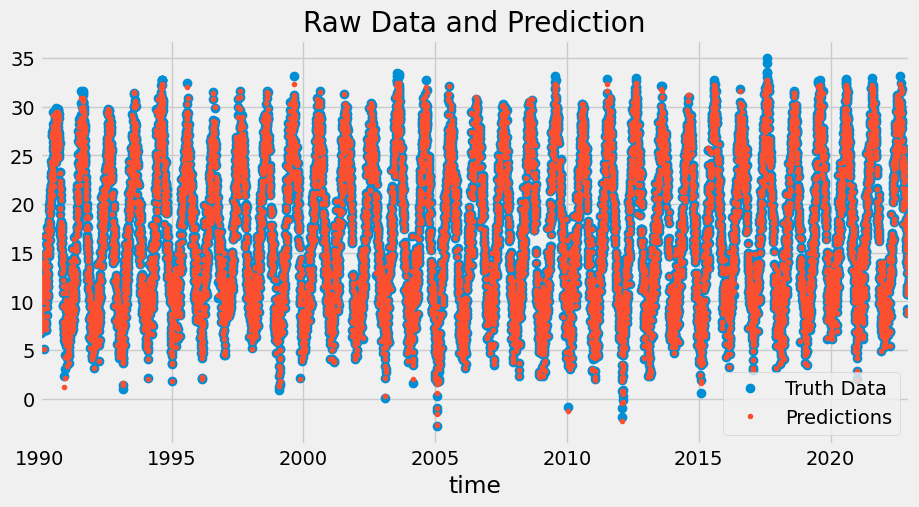

In [60]:
data_viz(apparent_temperature_mean_pred_df, 'apparent_temperature_mean', 'apparent_temperature_mean_pred')

### temperature_2m_mean

In [61]:
temperature_2m_mean = train_all_LSTM(weather_df, 'temperature_2m_mean', ['temperature_2m_mean', 'lag364', 'lag728'], 7, 364)

Epoch 1/7
34/34 - 3s - loss: 56.5078 - 3s/epoch - 97ms/step
Epoch 2/7
34/34 - 1s - loss: 26.4276 - 1s/epoch - 30ms/step
Epoch 3/7
34/34 - 1s - loss: 8.0255 - 982ms/epoch - 29ms/step
Epoch 4/7
34/34 - 1s - loss: 1.3798 - 973ms/epoch - 29ms/step
Epoch 5/7
34/34 - 1s - loss: 0.5118 - 990ms/epoch - 29ms/step
Epoch 6/7
34/34 - 1s - loss: 0.2179 - 986ms/epoch - 29ms/step
Epoch 7/7
34/34 - 1s - loss: 0.1129 - 994ms/epoch - 29ms/step
377/377 [==============================] - 2s 4ms/step


In [62]:
evaluation(temperature_2m_mean[1], temperature_2m_mean[3])

MSEs across folds 0.2891
Fold mses:0.2891020017646746
R2s across folds 0.9977
Fold R2s:0.9976538516098762


In [63]:
# b. Use saved model to create TARGET_pred values on historical data
weather_df = param_pred(weather_df, 'temperature_2m_mean_pred','temperature_2m_mean',
 ['temperature_2m_mean','lag364', 'lag728'] )

377/377 [==============================] - 2s 5ms/step


In [64]:
temperature_2m_mean_pred_df = create_target_df(weather_df, 'temperature_2m_mean', 'temperature_2m_mean_pred')

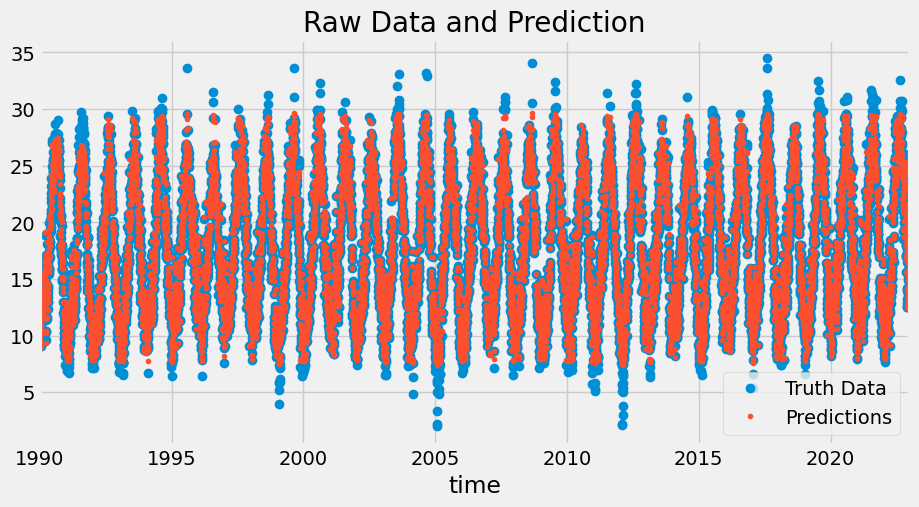

In [65]:
data_viz(temperature_2m_mean_pred_df, 'temperature_2m_mean', 'temperature_2m_mean_pred')

### temperature_2m_max

In [66]:
XGBoost_features_2m_max = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
estimators = 700
temperature_2m_max = train_all_XGBoost(weather_df, 'temperature_2m_max', XGBoost_features_2m_max, estimators)

[09:43:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [67]:
weather_df = param_pred_XGBoost(weather_df, 'temperature_2m_max_pred', 'temperature_2m_max', XGBoost_features_2m_max )

In [68]:
temperature_2m_max_pred_df = create_target_df(weather_df, 'temperature_2m_max', 'temperature_2m_max_pred')

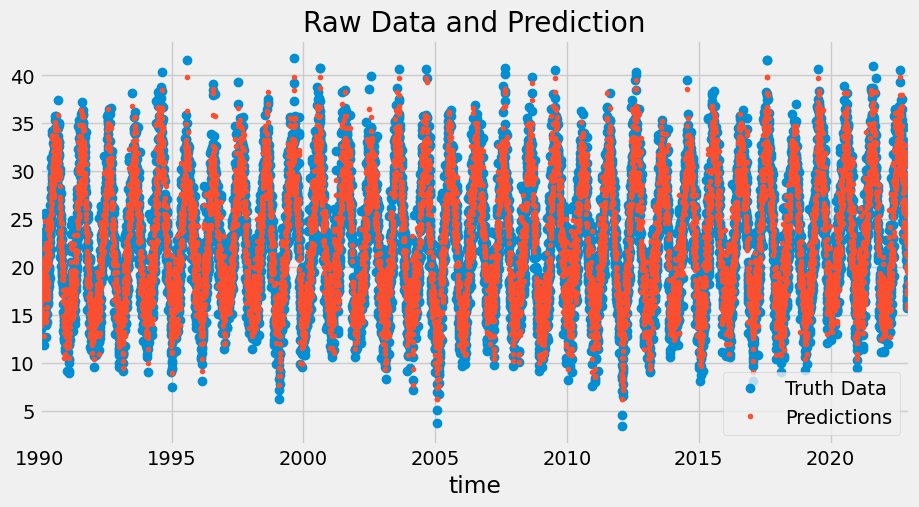

In [69]:
data_viz(temperature_2m_max_pred_df, 'temperature_2m_max', 'temperature_2m_max_pred')

### temperature_2m_min

In [70]:
XGBoost_features_2m_min = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
estimators = 700
temperature_2m_min = train_all_XGBoost(weather_df, 'temperature_2m_min', XGBoost_features_2m_min, estimators)

[09:43:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [71]:
weather_df = param_pred_XGBoost(weather_df, 'temperature_2m_min_pred', 'temperature_2m_min', XGBoost_features_2m_min )

In [72]:
temperature_2m_min_pred_df = create_target_df(weather_df, 'temperature_2m_min', 'temperature_2m_min_pred')

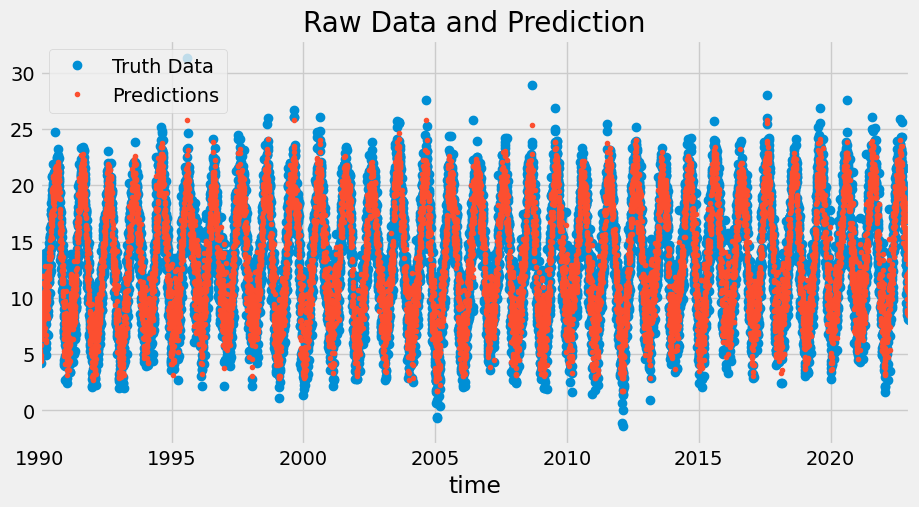

In [73]:
data_viz(temperature_2m_min_pred_df, 'temperature_2m_min', 'temperature_2m_min_pred')

### apparent_temperature_max

In [74]:
XGBoost_features_apparent_max = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
estimators = 700
temperature_apparent_max = train_all_XGBoost(weather_df, 'apparent_temperature_max', XGBoost_features_apparent_max, estimators)

[09:43:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [75]:
weather_df = param_pred_XGBoost(weather_df, 'apparent_temperature_max_pred', 'apparent_temperature_max', XGBoost_features_apparent_max )

In [76]:
apparent_temperature_max_pred_df = create_target_df(weather_df, 'apparent_temperature_max', 'apparent_temperature_max_pred')

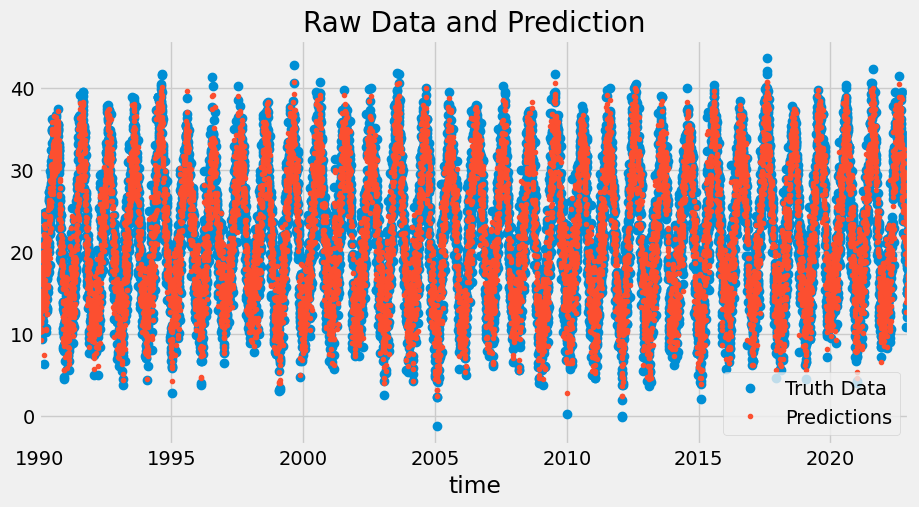

In [77]:
data_viz(apparent_temperature_max_pred_df, 'apparent_temperature_max', 'apparent_temperature_max_pred')

### apparent_temperature_min

In [78]:
XGBoost_features_apparent_min = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640' ]
estimators = 700
temperature_apparent_min = train_all_XGBoost(weather_df, 'apparent_temperature_min', XGBoost_features_apparent_min, estimators)

[09:43:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [79]:
weather_df = param_pred_XGBoost(weather_df, 'apparent_temperature_min_pred', 'apparent_temperature_min', XGBoost_features_apparent_min )

In [80]:
apparent_temperature_min_pred_df = create_target_df(weather_df, 'apparent_temperature_min', 'apparent_temperature_min_pred')

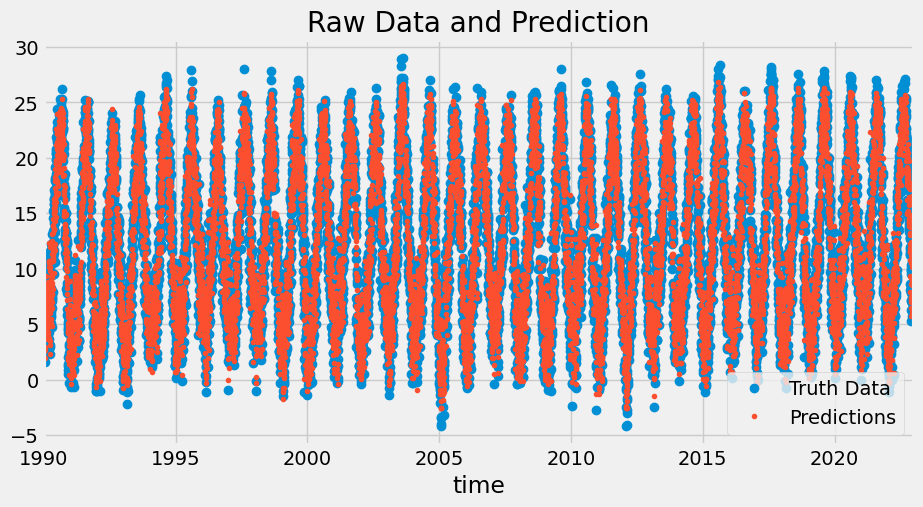

In [81]:
data_viz(apparent_temperature_min_pred_df, 'apparent_temperature_min', 'apparent_temperature_min_pred')

### et0_fao_evapotranspiration

In [82]:
XGBoost_features_et0_fao_evapotranspiration = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min','lag364', 'lag728', 'lag1092' ]
estimators = 700
et0_fao_evapotranspiration = train_all_XGBoost(weather_df, 'et0_fao_evapotranspiration', XGBoost_features_et0_fao_evapotranspiration, estimators)

[09:43:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [83]:
weather_df = param_pred_XGBoost(weather_df, 'et0_fao_evapotranspiration_pred', 'et0_fao_evapotranspiration', XGBoost_features_et0_fao_evapotranspiration )

In [84]:
et0_fao_evapotranspiration_pred_df = create_target_df(weather_df, 'et0_fao_evapotranspiration', 'et0_fao_evapotranspiration_pred')

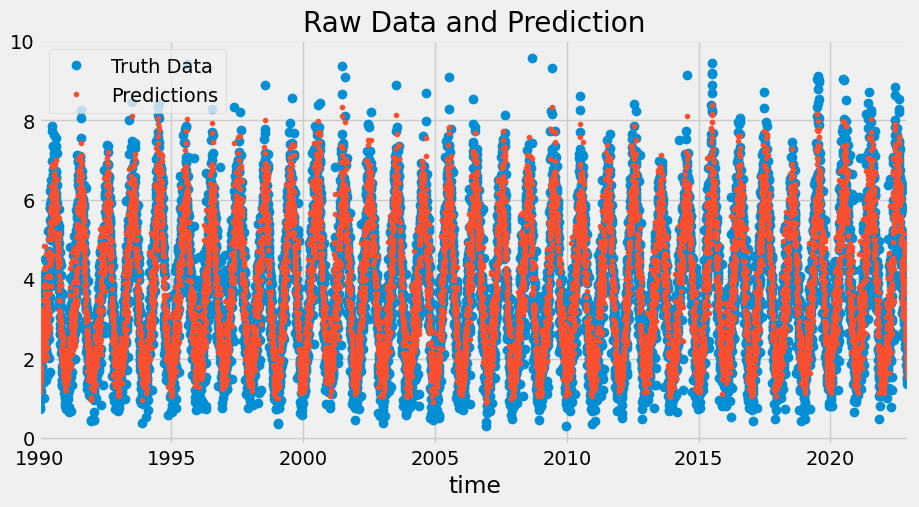

In [85]:
data_viz(et0_fao_evapotranspiration_pred_df, 'et0_fao_evapotranspiration', 'et0_fao_evapotranspiration_pred')

### precipitation_hours

In [86]:
XGBoost_features_precipitation_hours = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min', 'et0_fao_evapotranspiration', 'lag364',
                    'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
precipitation_hours = train_all_XGBoost(weather_df, 'precipitation_hours', XGBoost_features_precipitation_hours, estimators)

[09:44:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [87]:
weather_df = param_pred_XGBoost(weather_df, 'precipitation_hours_pred', 'precipitation_hours', XGBoost_features_precipitation_hours )

In [88]:
precipitation_hours_pred_df = create_target_df(weather_df, 'precipitation_hours', 'precipitation_hours_pred')

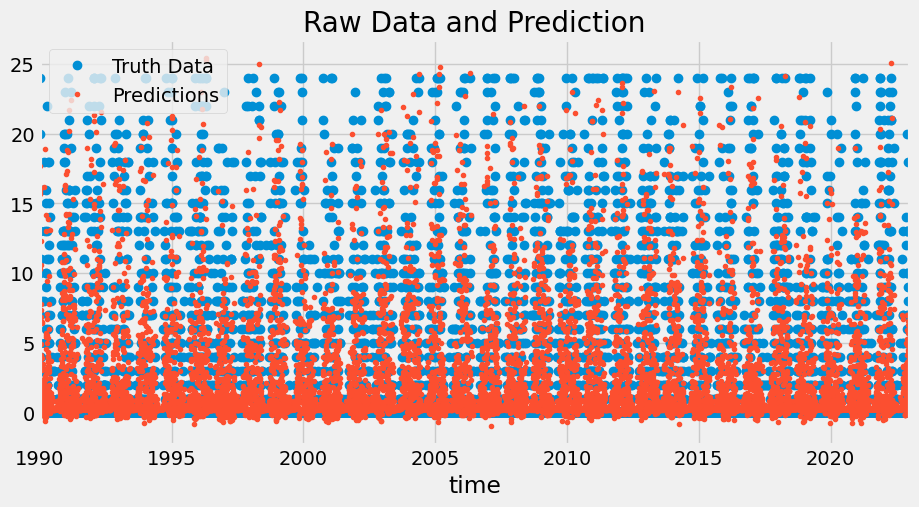

In [89]:
data_viz(precipitation_hours_pred_df, 'precipitation_hours', 'precipitation_hours_pred')

### precipitation_sum

In [90]:
XGBoost_features_precipitation_sum = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min', 'et0_fao_evapotranspiration', 'precipitation_hours',
                    'lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
precipitation_sum = train_all_XGBoost(weather_df, 'precipitation_sum', XGBoost_features_precipitation_sum, estimators)

[09:44:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [91]:
weather_df = param_pred_XGBoost(weather_df, 'precipitation_sum_pred', 'precipitation_sum', XGBoost_features_precipitation_sum)

In [92]:
precipitation_sum_pred_df = create_target_df(weather_df, 'precipitation_sum', 'precipitation_sum_pred')

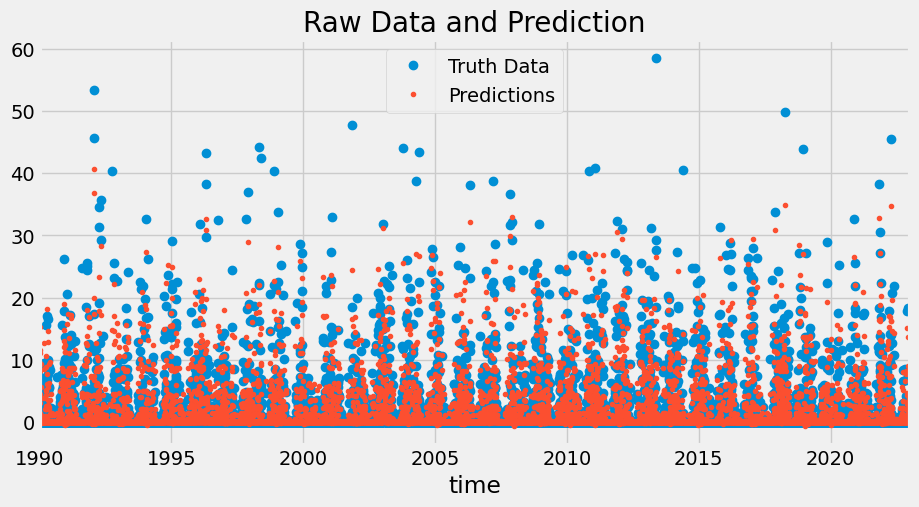

In [93]:
data_viz(precipitation_sum_pred_df, 'precipitation_sum', 'precipitation_sum_pred')

### windspeed_10m_max

In [94]:
XGBoost_features_windspeed_10m_max = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min', 'et0_fao_evapotranspiration', 'precipitation_hours',
                    'precipitation_sum','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
windspeed_10m_max = train_all_XGBoost(weather_df, 'windspeed_10m_max', XGBoost_features_windspeed_10m_max, estimators)

[09:44:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [95]:
weather_df = param_pred_XGBoost(weather_df, 'windspeed_10m_max_pred', 'windspeed_10m_max', XGBoost_features_windspeed_10m_max)

In [96]:
windspeed_10m_max_pred_df = create_target_df(weather_df, 'windspeed_10m_max', 'windspeed_10m_max_pred')

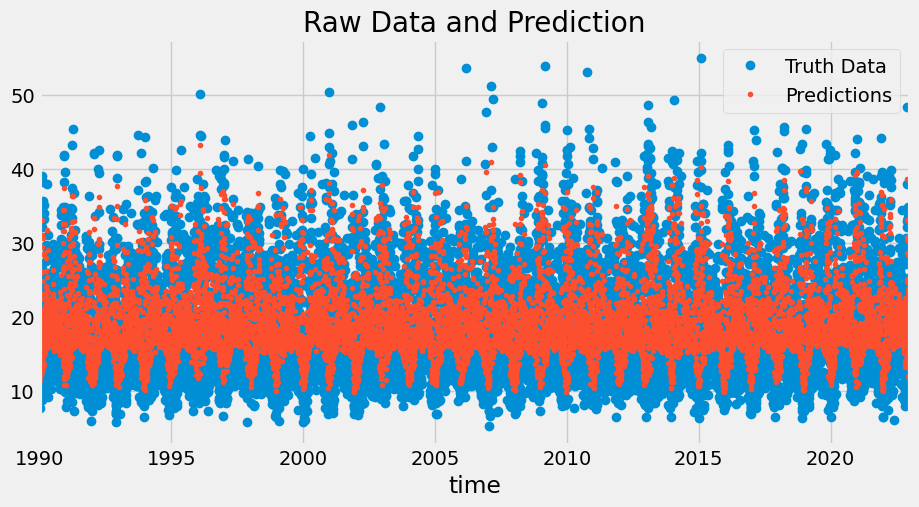

In [97]:
data_viz(windspeed_10m_max_pred_df, 'windspeed_10m_max', 'windspeed_10m_max_pred')

### windgusts_10m_max

In [98]:
XGBoost_features_windgusts_10m_max = ['month', 'year', 'dayofyear','temperature_2m_mean' , 'apparent_temperature_mean',
                    'temperature_2m_max','temperature_2m_min','apparent_temperature_max',
                    'apparent_temperature_min', 'et0_fao_evapotranspiration', 'precipitation_hours',
                    'precipitation_sum', 'windspeed_10m_max','lag364', 'lag728', 'lag1092', 'lag1820', 'lag3640'  ]
estimators = 700
windgusts_10m_max = train_all_XGBoost(weather_df, 'windgusts_10m_max', XGBoost_features_windgusts_10m_max, estimators)

[09:44:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [99]:
weather_df = param_pred_XGBoost(weather_df, 'windgusts_10m_max_pred', 'windgusts_10m_max', XGBoost_features_windgusts_10m_max)

In [100]:
windgusts_10m_max_pred_df = create_target_df(weather_df, 'windgusts_10m_max', 'windgusts_10m_max_pred')

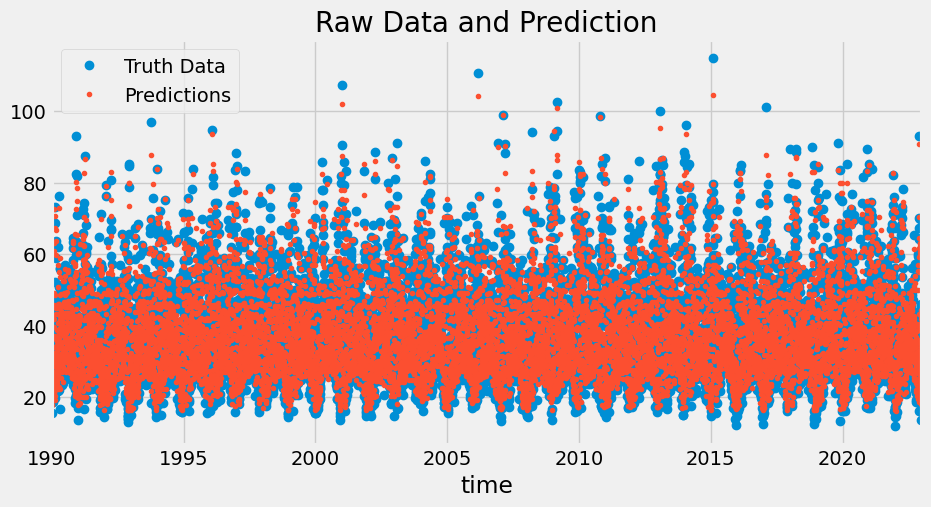

In [101]:
data_viz(windgusts_10m_max_pred_df, 'windgusts_10m_max', 'windgusts_10m_max_pred')

## 2. Make future predictions

### apparent_temperature_mean

In [102]:
# Create future dataframe
apparent_temperature_mean_pred_df = create_df_and_future(apparent_temperature_mean_pred_df)

In [103]:
# Calculate future predictions
apparent_temperature_mean_pred_df = param_pred(apparent_temperature_mean_pred_df, 'apparent_temperature_mean_pred','apparent_temperature_mean',
 ['apparent_temperature_mean','lag364', 'lag728'] )

389/389 [==============================] - 2s 4ms/step


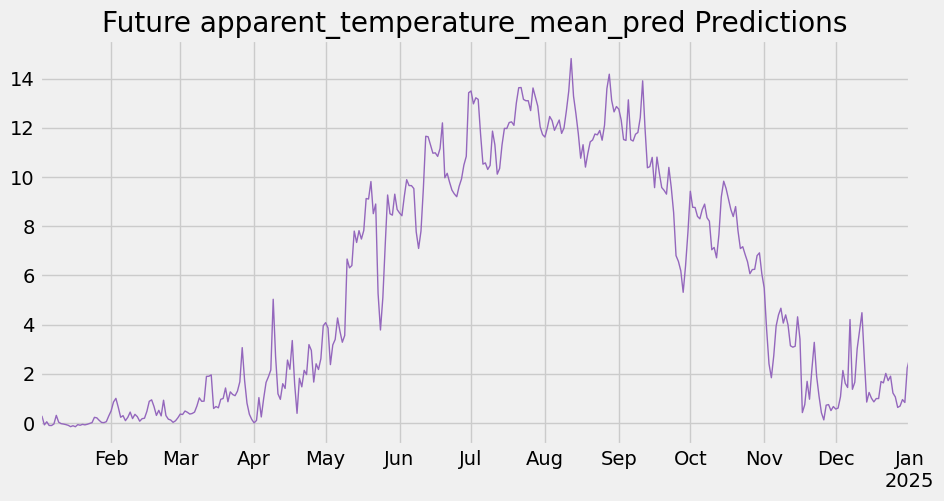

In [104]:
# Visualize predictions
future_pred_viz(apparent_temperature_mean_pred_df[apparent_temperature_mean_pred_df.index > '2024-01-01'], 'apparent_temperature_mean_pred')

### temperature_2m_mean

In [105]:
temperature_2m_mean_pred_df = create_df_and_future(temperature_2m_mean_pred_df)

In [106]:
temperature_2m_mean_pred_df = param_pred(temperature_2m_mean_pred_df, 'temperature_2m_mean_pred','temperature_2m_mean',
 ['temperature_2m_mean','lag364', 'lag728'] )

389/389 [==============================] - 2s 4ms/step


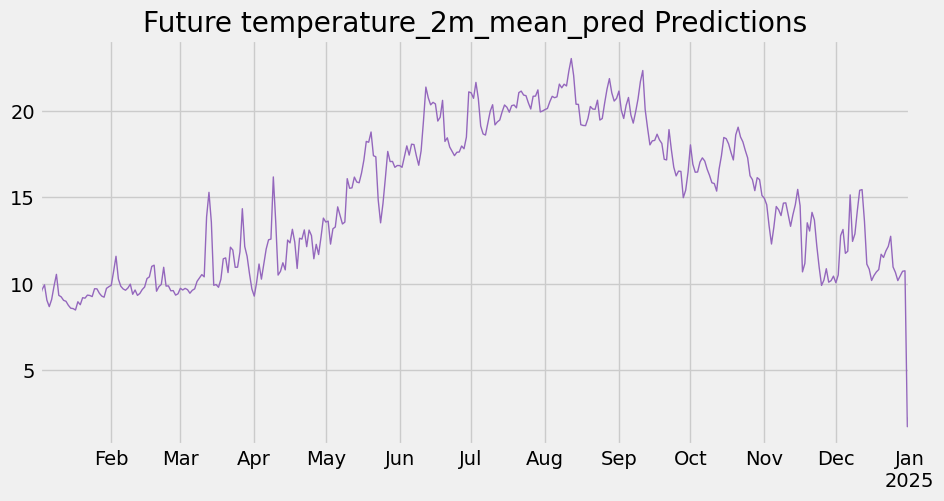

In [107]:
future_pred_viz(temperature_2m_mean_pred_df[temperature_2m_mean_pred_df.index > '2024-01-01'], 'temperature_2m_mean_pred')

### temperature_2m_max

In [108]:
temperature_2m_max_pred_df = create_df_and_future(weather_df)

In [109]:
temperature_2m_max_pred_df = param_pred_XGBoost(temperature_2m_max_pred_df, 'temperature_2m_max_pred','temperature_2m_max', XGBoost_features_2m_max )

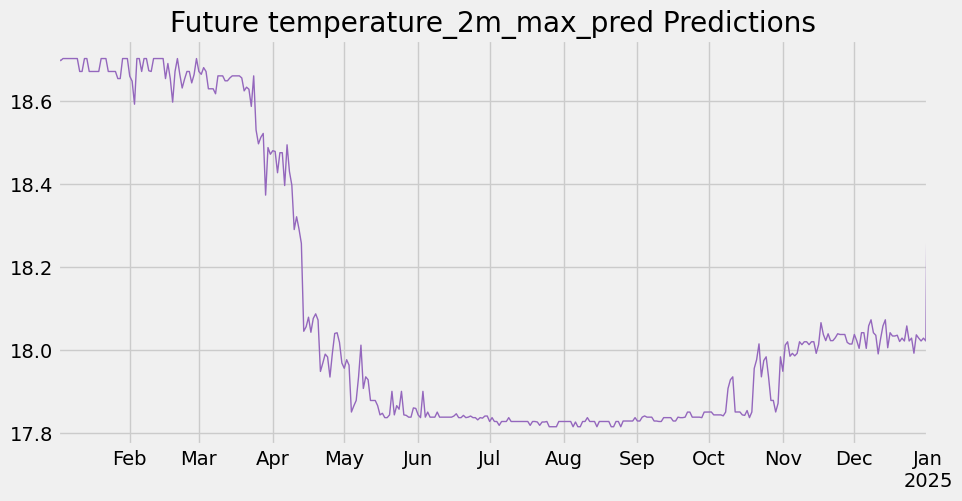

In [110]:
future_pred_viz(temperature_2m_max_pred_df[temperature_2m_max_pred_df.index > '2024-01-01'], 'temperature_2m_max_pred')

### temperature_2m_min

In [111]:
temperature_2m_min_pred_df = create_df_and_future(weather_df)

In [112]:
temperature_2m_min_pred_df = param_pred_XGBoost(temperature_2m_min_pred_df, 'temperature_2m_min_pred','temperature_2m_min', XGBoost_features_2m_min )

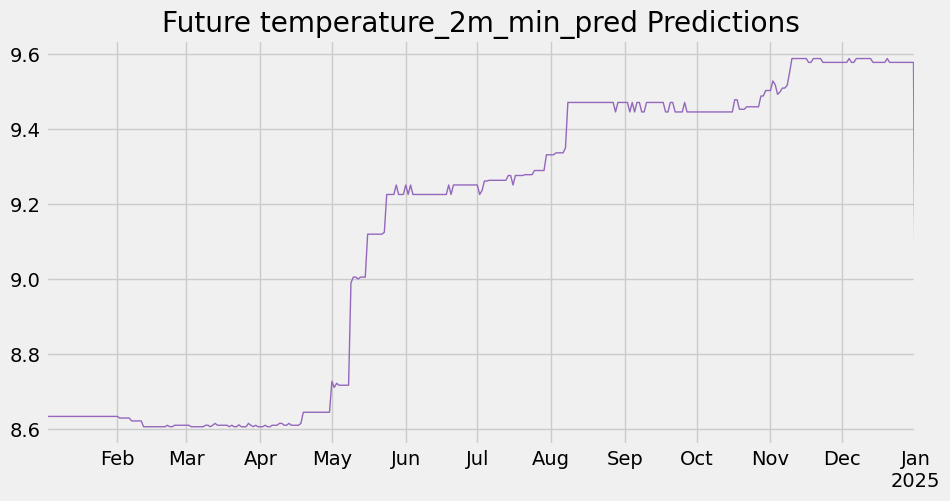

In [113]:
future_pred_viz(temperature_2m_min_pred_df[temperature_2m_min_pred_df.index > '2024-01-01'], 'temperature_2m_min_pred')

### apparent_temperature_max

In [114]:
apparent_temperature_max_pred_df = create_df_and_future(weather_df)

In [115]:
apparent_temperature_max_pred_df = param_pred_XGBoost(apparent_temperature_max_pred_df, 'apparent_temperature_max_pred','apparent_temperature_max', XGBoost_features_apparent_max )

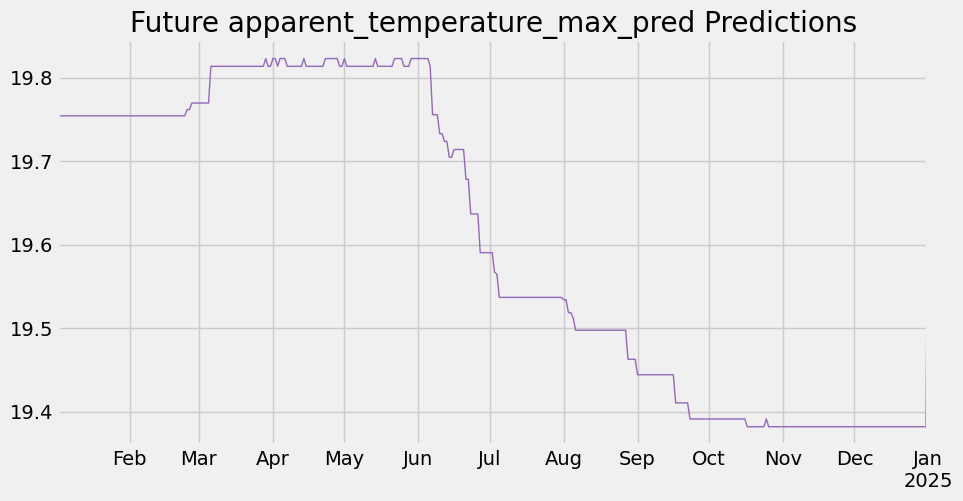

In [116]:
future_pred_viz(apparent_temperature_max_pred_df[apparent_temperature_max_pred_df.index > '2024-01-01'], 'apparent_temperature_max_pred')

### apparent_temperature_min

In [117]:
apparent_temperature_min_pred_df = create_df_and_future(weather_df)

In [118]:
apparent_temperature_min_pred_df = param_pred_XGBoost(apparent_temperature_min_pred_df, 'apparent_temperature_min_pred','apparent_temperature_min', XGBoost_features_apparent_min )

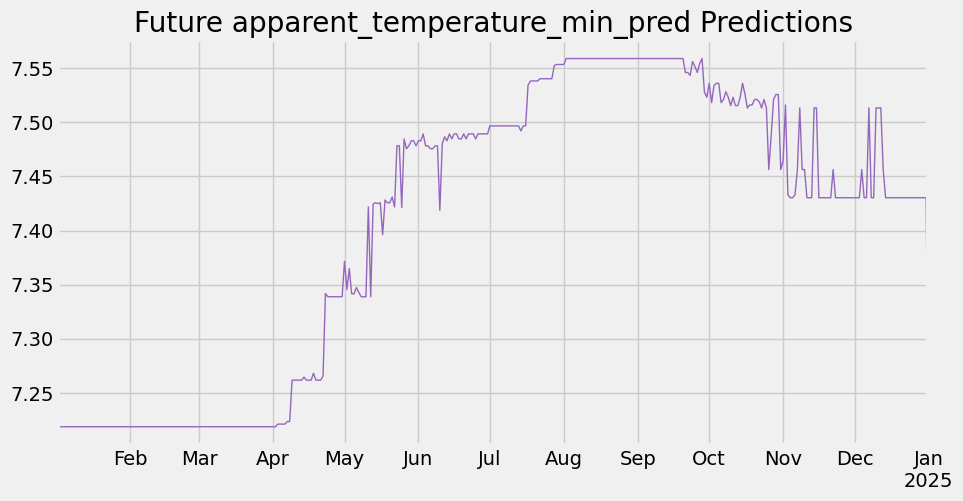

In [119]:
future_pred_viz(apparent_temperature_min_pred_df[apparent_temperature_min_pred_df.index > '2024-01-01'], 'apparent_temperature_min_pred')

### et0_fao_evapotranspiration

In [120]:
et0_fao_evapotranspiration_pred_df = create_df_and_future(weather_df)

In [121]:
et0_fao_evapotranspiration_pred_df = param_pred_XGBoost(et0_fao_evapotranspiration_pred_df, 'et0_fao_evapotranspiration_pred','et0_fao_evapotranspiration', XGBoost_features_et0_fao_evapotranspiration )

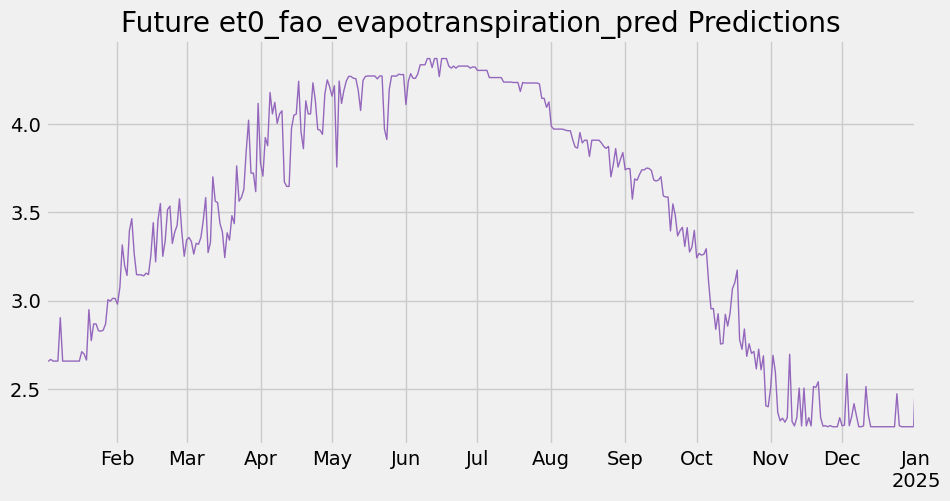

In [122]:
future_pred_viz(et0_fao_evapotranspiration_pred_df[et0_fao_evapotranspiration_pred_df.index > '2024-01-01'], 'et0_fao_evapotranspiration_pred')

### precipitation_hours

In [123]:
precipitation_hours_pred_df = create_df_and_future(weather_df)

In [124]:
precipitation_hours_pred_df = param_pred_XGBoost(precipitation_hours_pred_df, 'precipitation_hours_pred','precipitation_hours', XGBoost_features_precipitation_hours )

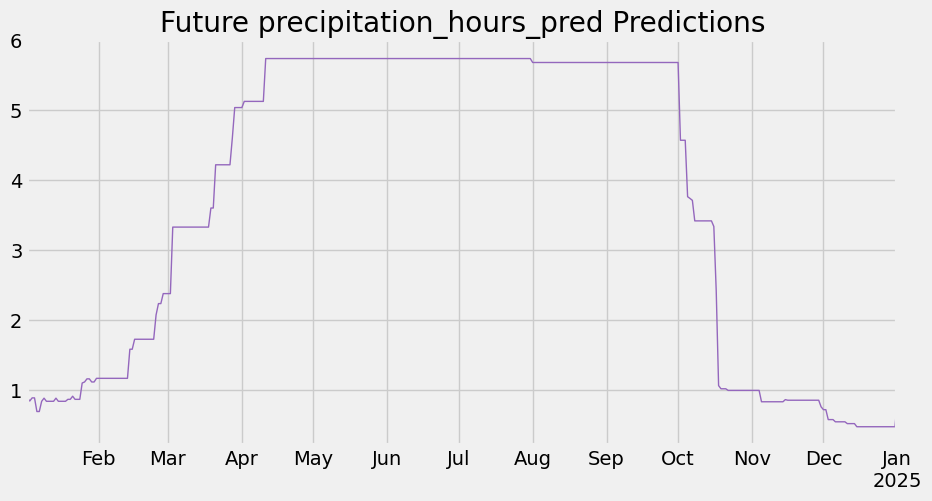

In [125]:
future_pred_viz(precipitation_hours_pred_df[precipitation_hours_pred_df.index > '2024-01-01'], 'precipitation_hours_pred')

### precipitation_sum

In [126]:
precipitation_sum_pred_df = create_df_and_future(weather_df)

In [127]:
precipitation_sum_pred_df = param_pred_XGBoost(precipitation_sum_pred_df, 'precipitation_sum_pred','precipitation_sum', XGBoost_features_precipitation_sum )

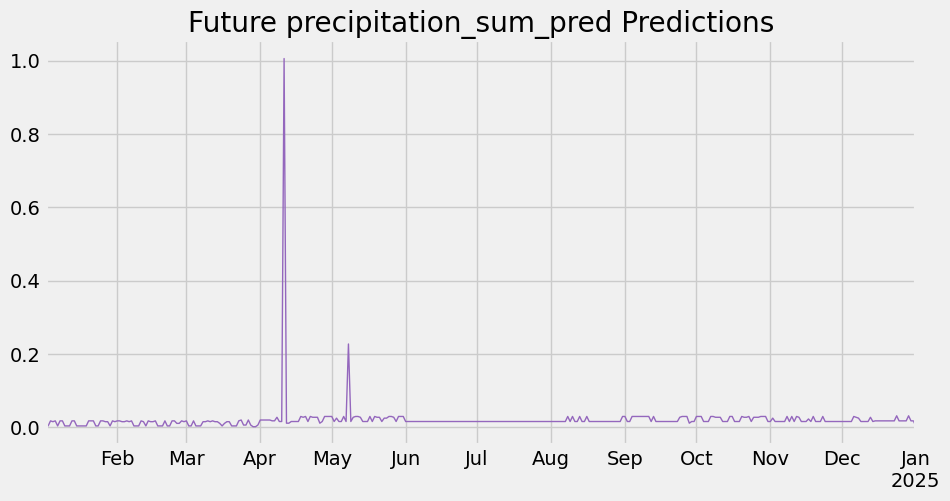

In [128]:
future_pred_viz(precipitation_sum_pred_df[precipitation_sum_pred_df.index > '2024-01-01'], 'precipitation_sum_pred')

### windspeed_10m_max

In [129]:
windspeed_10m_max_pred_df = create_df_and_future(weather_df)

In [130]:
windspeed_10m_max_pred_df = param_pred_XGBoost(windspeed_10m_max_pred_df, 'windspeed_10m_max_pred','windspeed_10m_max', XGBoost_features_windspeed_10m_max )

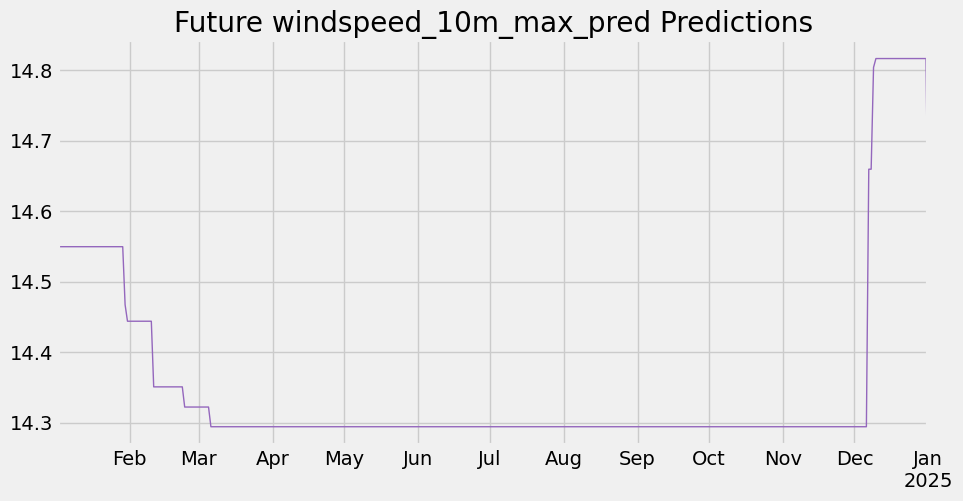

In [131]:
future_pred_viz(windspeed_10m_max_pred_df[windspeed_10m_max_pred_df.index > '2024-01-01'], 'windspeed_10m_max_pred')

### windgusts_10m_max

In [132]:
windgusts_10m_max_pred_df = create_df_and_future(weather_df)

In [133]:
windgusts_10m_max_pred_df = param_pred_XGBoost(windgusts_10m_max_pred_df, 'windgusts_10m_max_pred','windgusts_10m_max', XGBoost_features_windgusts_10m_max )

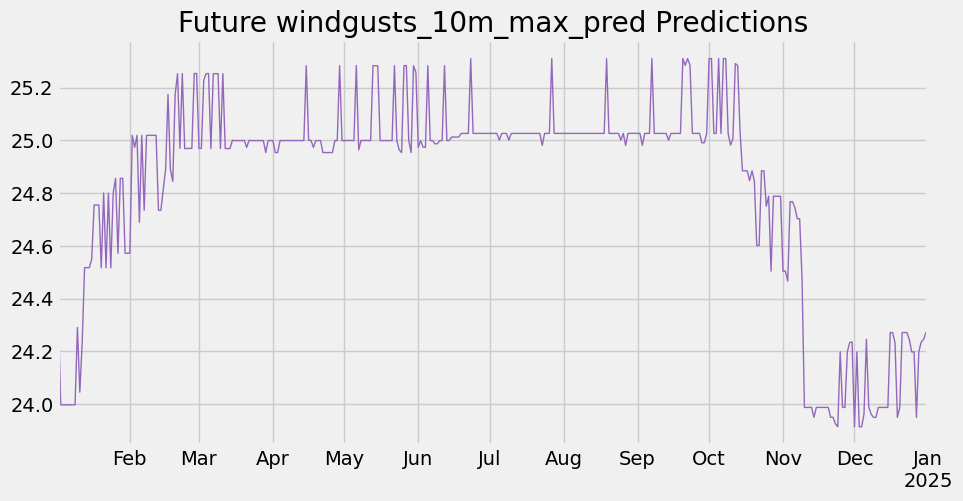

In [134]:
future_pred_viz(windgusts_10m_max_pred_df[windgusts_10m_max_pred_df.index > '2024-01-01'], 'windgusts_10m_max_pred')